Site to Database: https://www.ncbi.nlm.nih.gov/geo/

### Load packages

In [1]:
library(Biobase)
library(GEOquery)
library(limma)
library(repr)
library(edgeR)
library(preprocessCore)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite B

# **Microarray Data**

Specify directory for where to store Differential Gene Expression Data

In [2]:
microarray_diff_exp_data <- "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Microarray Differential Gene Expression/ATB_v_LTBI/"

## *Function* to subset rows of normalized gene expression matrix

- The function maps each gene symbol to the probe with the highest gene expression sum across all samples in the matrix. 
- It then filters the matrix accordingly and drops rows/probes that either 
    1. did not map to any gene symbol
    1. mapped to some gene symbol **x** but had lower expression sum across samples than another probe that mapped to gene symbol **x**

In [3]:
#define operator
`%notin%` <- Negate(`%in%`)

reduce_expression_matrix_rows <- function(gset, microarray_platform) {
    
    #filter rows of exp matrix, keep only one probe per gene (symbol) with the highest expression sum across samples
    
    #useful commands for de-bugging
    # gset
    # varLabels(featureData(gset))

    #store expression matrix & get the sum for each row/probe from expression matrix
    exp_matrix <- exprs(gset)
    probe_sums <- rowSums(exp_matrix)
    probe_IDs <- names(probe_sums)

    #iterate through all rows/probes and store non-redundant gene symbols (first check to see that string is not empty) store in vector

    #initialize list that will hold information for each row/probe: probe ID (index), list[vector(gene symbols), float(row/probe exp sum)]
    probe_info <- list()

    if ((microarray_platform == 'GPL6947') | (microarray_platform == 'GPL4133') | (microarray_platform == 'GPL10558') | (microarray_platform == 'GPL570') | (microarray_platform == 'GPL11532') | (microarray_platform == 'GPL6102') | (microarray_platform == 'GPL6480') | (microarray_platform == 'GPL6883')) {

        gene_symbol_labels <- fData(gset)$Gene.symbol #get the gene symbols mapped to each row/probe

        i <- 1 #indexes rows/probes
        for (gene_symbol_i in gene_symbol_labels) {

            #get info for row
            probe_i_ID = probe_IDs[i]
            probe_i_sum = probe_sums[i]
            probe_i_gene_symbols = vector()

            #multiple genes
            if ((gene_symbol_i != '') & grepl('///', gene_symbol_i, fixed = TRUE)) {

                for (gene_symbol_j in unlist(strsplit(gene_symbol_i, '///', fixed = TRUE))) {
                    probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_j))
                }
            #one gene
            } else if (gene_symbol_i != '') {

                probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_i))
            }
            probe_info[[probe_i_ID]] <- list(probe_i_gene_symbols, probe_i_sum)
            i = i + 1
        }
    } else if (microarray_platform == 'GPL5175') {

        gene_symbol_labels <- fData(gset)$gene_assignment #get the gene symbols mapped to each row/probe

        i <- 1 #indexes rows/probes
        for (gene_assignment_i in gene_symbol_labels) {

            #get info for row
            probe_i_ID = probe_IDs[i]
            probe_i_sum = probe_sums[i]
            probe_i_gene_symbols = vector()

            #multiple genes
            if ((gene_assignment_i != '') & grepl('///', gene_assignment_i, fixed = TRUE)) {

                for (gene_assignment_j in unlist(strsplit(gene_assignment_i , '///' , fixed = TRUE))) {
                    gene_symbol_i <- unlist(strsplit(gene_assignment_j, '//'))[2]
                    probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_i))
                }
            #one gene
            } else if ((gene_assignment_i != '') & grepl('//', gene_assignment_i, fixed = TRUE)) {

                gene_symbol_i <- unlist(strsplit(gene_assignment_i, '//'))[2]
                probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_i))
            }   
            probe_info[[probe_i_ID]] <- list(probe_i_gene_symbols, probe_i_sum)
            i = i + 1
        }
    } else if (microarray_platform == 'GPL16951') {

        gene_symbol_labels <- fData(gset)$Gene_symbol #get the gene symbols mapped to each row/probe

        i <- 1 #indexes rows/probes
        for (gene_symbol_i in gene_symbol_labels) {

            #get info for row
            probe_i_ID = probe_IDs[i]
            probe_i_sum = probe_sums[i]
            probe_i_gene_symbols = vector()

            #multiple genes
            if ((gene_symbol_i != 'previous version conserved probe') & (gene_symbol_i != '') & grepl('|', gene_symbol_i, fixed = TRUE)) {

                for (gene_symbol_j in unlist(strsplit(gene_symbol_i, '|', fixed = TRUE))) {
                    probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_j))
                }
            #one gene
            } else if ((gene_symbol_i != 'previous version conserved probe') & (gene_symbol_i != '')) {

                probe_i_gene_symbols <- c(probe_i_gene_symbols, trimws(gene_symbol_i))
            }   
            probe_info[[probe_i_ID]] <- list(probe_i_gene_symbols, probe_i_sum)
            i = i + 1
        }
    }

    #iterate through each probe - gene symbol list - gene exp sum, keep track of the probe with the largest sum (across samples) for each gene symbol
    #> each gene symbol will get mapped to only the row/probe with the highest expression sum across samples
    probe_exp_sum_by_gene = list()
    for (probe_i in names(probe_info)) {

        gene_symbol_vec_probe_i = probe_info[probe_i][[1]][[1]] #holds the vector of gene symbols
        gene_symbol_exp_sum = unname(probe_info[probe_i][[1]][[2]]) #holds the probe exp sum (total across samples)

        #iterate through gene symbols that correspond to this probe (if there are any)
        if (length(gene_symbol_vec_probe_i) > 0) { #there's at least 1 gene symbol
            for (gene_symbol_i in gene_symbol_vec_probe_i) { #iterate through gene symbols

                #if gene symbol not present in list, then store gene symbol along with (probe exp sum) & (probe ID)
                if (gene_symbol_i %notin% names(probe_exp_sum_by_gene)) {
                    probe_exp_sum_by_gene[[gene_symbol_i]] <- list(probe_i, gene_symbol_exp_sum)

                #if gene symbol is present in list, then replace gene symbol along with (probe exp sum) & (probe ID) IF (probe exp sum) > than the (probe exp sum) currently in list
                } else if ((gene_symbol_i %in% names(probe_exp_sum_by_gene)) & (gene_symbol_exp_sum > probe_exp_sum_by_gene[[gene_symbol_i]][[2]])) {
                    probe_exp_sum_by_gene[[gene_symbol_i]] <- list(probe_i, gene_symbol_exp_sum)
                }
            }
        }
    }

    #create a vector of probe IDs we want to keep
    probe_IDs_to_keep <- vector()
    for (gene_symbol_i in names(probe_exp_sum_by_gene)) {
        probe_IDs_to_keep <- c(probe_IDs_to_keep, probe_exp_sum_by_gene[[gene_symbol_i]][[1]])
    }
    #some probe IDs may be duplicated since some probes map to multiple genes
    probe_IDs_to_keep <- unique(probe_IDs_to_keep)

    #create a boolean vector to filter Gene Expression matrix (TRUE = keep row/probe , FALSE = drop probe)
    exp_probe_bool_filter = vector()
    for (probe_id in row.names(exp_matrix)) {
        if (probe_id %in% probe_IDs_to_keep) {
            exp_probe_bool_filter <- c(exp_probe_bool_filter, TRUE)
        } else {
            exp_probe_bool_filter <- c(exp_probe_bool_filter, FALSE)
        }
    }

    #subset to rows that have the highest expression sums for each gene
    sel <- which(exp_probe_bool_filter == TRUE)
    gset <- gset[sel, ]
    return(gset)
}

## *Function* to draw boxplot

In [4]:
draw_boxplot_for_samples <- function(GSE_ID, microarray_platform, gsms, labels, qnorm) {
        
    # Boxplot for selected GEO samples

    # load series and platform data from GEO
    gset <- getGEO(GSE_ID, GSEMatrix =TRUE, getGPL=FALSE)
    if (length(gset) > 1) idx <- grep(microarray_platform, attr(gset, "names")) else idx <- 1
    gset <- gset[[idx]]

    # group names for all samples in a series
    sml <- c()
    for (i in 1:nchar(gsms)) { sml[i] <- substr(gsms,i,i) }
    sml <- paste("G", sml, sep="")  # set group names

    # eliminate samples marked as "X"
    sel <- which(sml != "X")
    sml <- sml[sel]
    gset <- gset[ ,sel]

    # order samples by group
    ex <- exprs(gset)[ , order(sml)]
    sml <- sml[order(sml)]
    fl <- as.factor(sml)
    
    # log2 transform
    qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
    LogC <- (qx[5] > 100) ||
              (qx[6]-qx[1] > 50 && qx[2] > 0) ||
              (qx[2] > 0 && qx[2] < 1 && qx[4] > 1 && qx[4] < 2)
    if (LogC) { ex[which(ex <= 0)] <- NaN
        exprs(gset) <- log2(ex)
        ex <- exprs(gset)}

    # perform quantile normalization
    if (qnorm == TRUE) {
        col_names <- colnames(exprs(gset))
        row_names <- rownames(exprs(gset))
        exprs(gset) <- preprocessCore::normalize.quantiles(exprs(gset))
        colnames(exprs(gset)) <- col_names
        rownames(exprs(gset)) <- row_names
        ex <- exprs(gset) }

    # set parameters and draw the plot
    palette(c("#dfeaf4","#dff4e4", "#AABBCC"))
    options(repr.plot.width=4+dim(gset)[[2]]/5, repr.plot.height=6)
    par(mar=c(2+round(max(nchar(sampleNames(gset)))/2),4,2,1))
    title <- paste (GSE_ID, '/', annotation(gset), " selected samples", sep ='')
    boxplot(ex, boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=fl)
    legend("topleft", labels, fill=palette(), bty="n")
}

## *Function* for differential gene expression analysis

In [5]:
diff_exp_analysis_for_samples <- function(GSE_ID, microarray_platform, gsms, microarray_diff_exp_data, qnorm) {
    
    # Differential expression analysis with limma

    # load series and platform data from GEO
    gset <- getGEO(GSE_ID, GSEMatrix =TRUE, AnnotGPL=TRUE)
    if (length(gset) > 1) idx <- grep(microarray_platform, attr(gset, "names")) else idx <- 1
    gset <- gset[[idx]]

    # make proper column names to match toptable 
    fvarLabels(gset) <- make.names(fvarLabels(gset))

    # Reduce rows to one probe per gene (keep probes with the highest expression sum across samples)
    gset <- reduce_expression_matrix_rows(gset, microarray_platform)

    # group names for all samples
    sml <- c()
    for (i in 1:nchar(gsms)) { sml[i] <- substr(gsms,i,i) }

    # eliminate samples marked as "X"
    sel <- which(sml != "X")
    sml <- sml[sel]
    gset <- gset[ ,sel]

    # log2 transform
    ex <- exprs(gset)
    qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
    LogC <- (qx[5] > 100) ||
              (qx[6]-qx[1] > 50 && qx[2] > 0) ||
              (qx[2] > 0 && qx[2] < 1 && qx[4] > 1 && qx[4] < 2)
    if (LogC) { ex[which(ex <= 0)] <- NaN
      exprs(gset) <- log2(ex) }

    # perform quantile normalization
    if (qnorm == TRUE) {
        col_names <- colnames(exprs(gset))
        row_names <- rownames(exprs(gset))
        exprs(gset) <- preprocessCore::normalize.quantiles(exprs(gset))
        colnames(exprs(gset)) <- col_names
        rownames(exprs(gset)) <- row_names }

    # set up the data and proceed with analysis
    sml <- paste("G", sml, sep="")    # set group names
    fl <- as.factor(sml)
    gset$description <- fl
    design <- model.matrix(~ description + 0, gset)
    colnames(design) <- levels(fl)
    fit <- lmFit(gset, design)
    cont.matrix <- makeContrasts(G1-G0, levels=design)
    fit2 <- contrasts.fit(fit, cont.matrix)
    fit2 <- eBayes(fit2, 0.01)
    tT <- topTable(fit2, adjust="fdr", sort="none" , n=Inf)

    write.csv(tT, paste0(microarray_diff_exp_data , GSE_ID, '.csv'))
}

## Dataset 1

### GSE19491: GSE19439: Blood Transcriptional Profiles in Active and Latent Tuberculosis UK (microarray, GPL6947)

- Subjects:42 
- Disease status: PTB (Active Pulmonary TB) (n=13), Latent (n=17), Control (BCG+)(n=6), Control (BCG-)(n=6)
- Disease status definition: PTB-isolation of Mycobacterium Tuberculosis on culture of sputum or bronchoalvelolar lavage fluid. Latent-positive by tuberculin skin test (>14mm if BCG vaccinated, >5mm if not vaccinated) and were also positive by Interferon-Gamma Release assay(IGRA). Control :negative for both assays.

Compare ATB (**n=13**) to LTBI (**n=17**)

In [6]:
gsms <- "01X10XX01X0100X10X10101010110X1XXX0X010X00"
labels <- c("LTBI","ATB")
GSE_ID <- "GSE19439"
microarray_platorm <- "GPL6947"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE19439_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


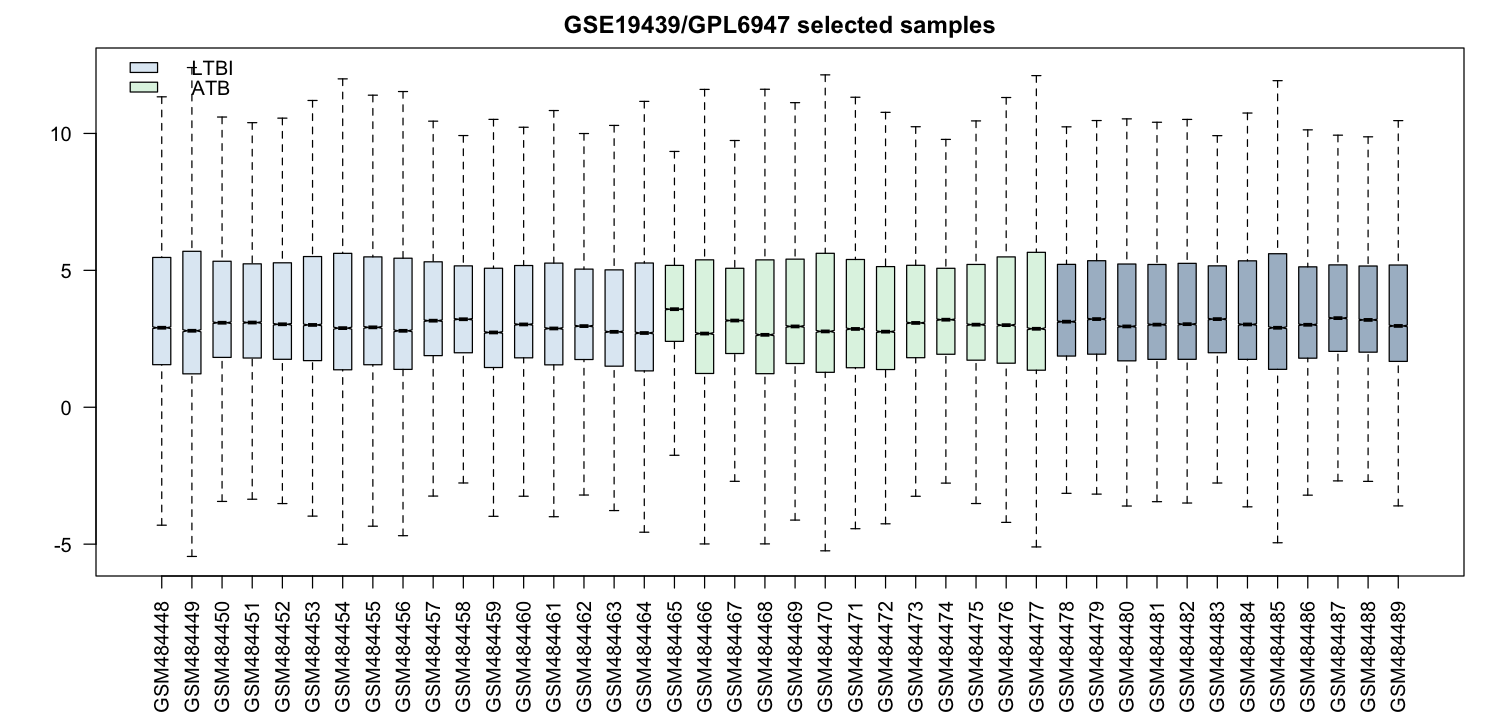

In [7]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE19439_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE19439_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


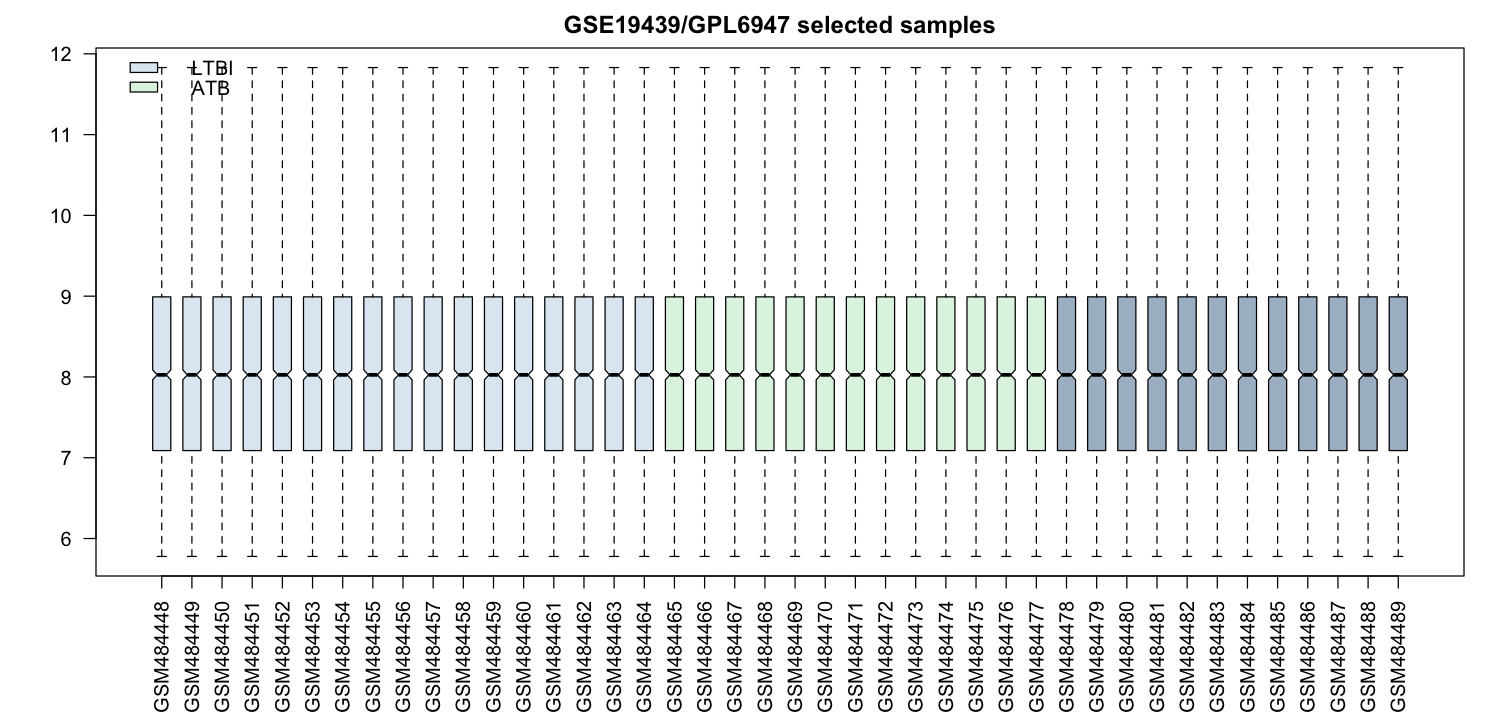

In [8]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [9]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE19439_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE19439_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL6947.annot.gz
Warning message:
“Partial NA coefficients for 729 probe(s)”Warning message:
“Zero sample variances detected, have been offset away from zero”

## Dataset 2

### GSE19491: GSE19442:	Blood Transcriptional Profiles of TB in South Africa (microarray, GPL6947)

- Subjects:51
- Disease status: PTB (n=20), LATENT TB (n=31)
- Disease status definition: same as above

Compare ATB (**n=20**) to LTBI (**n=31**)

In [10]:
gsms <- "111100000000000111110000111100000111100000011100000"
labels <- c("LTBI","ATB")
GSE_ID <- "GSE19442"
microarray_platorm <- "GPL6947"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE19442_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


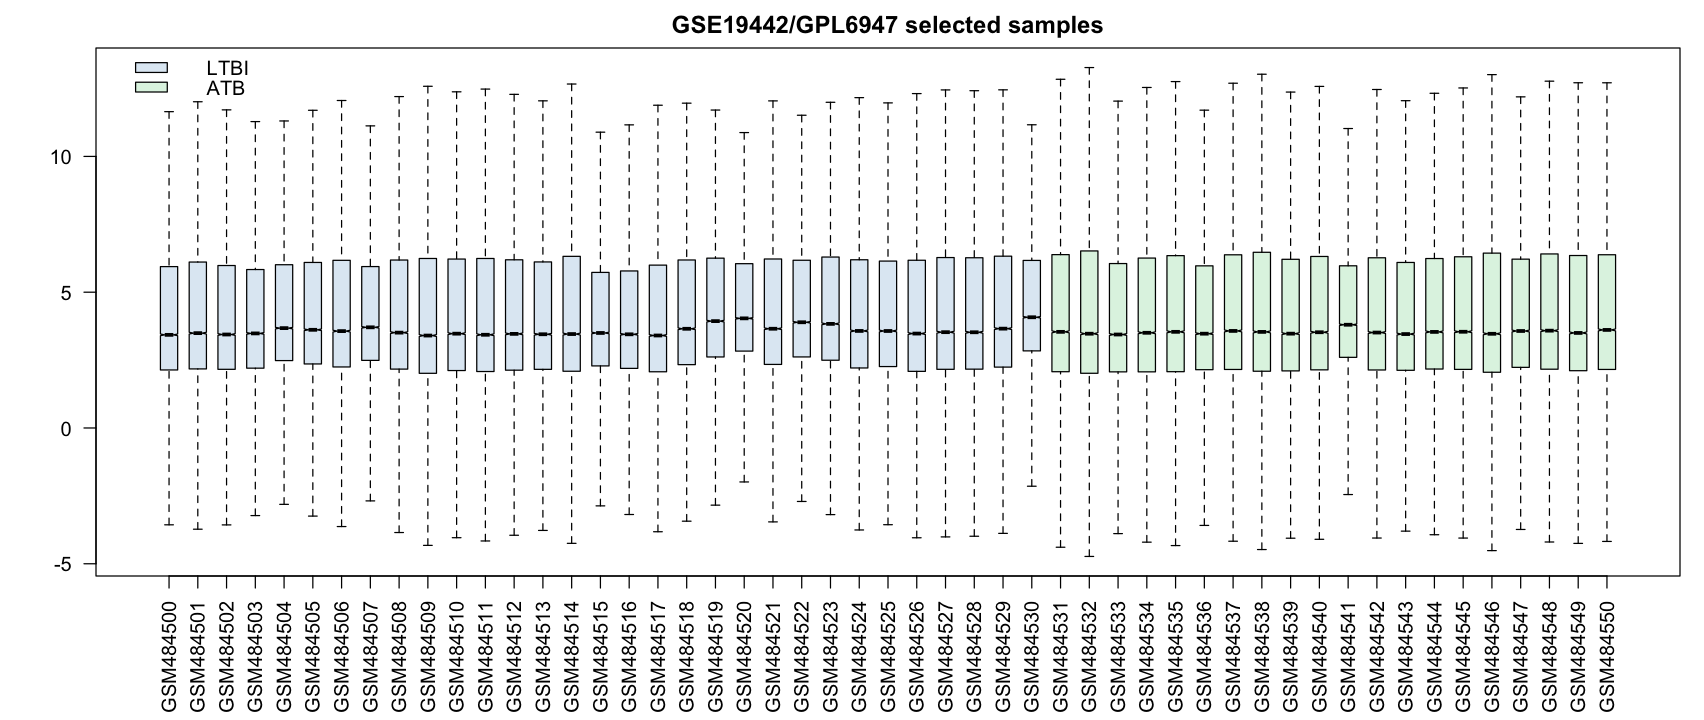

In [11]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE19442_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE19442_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


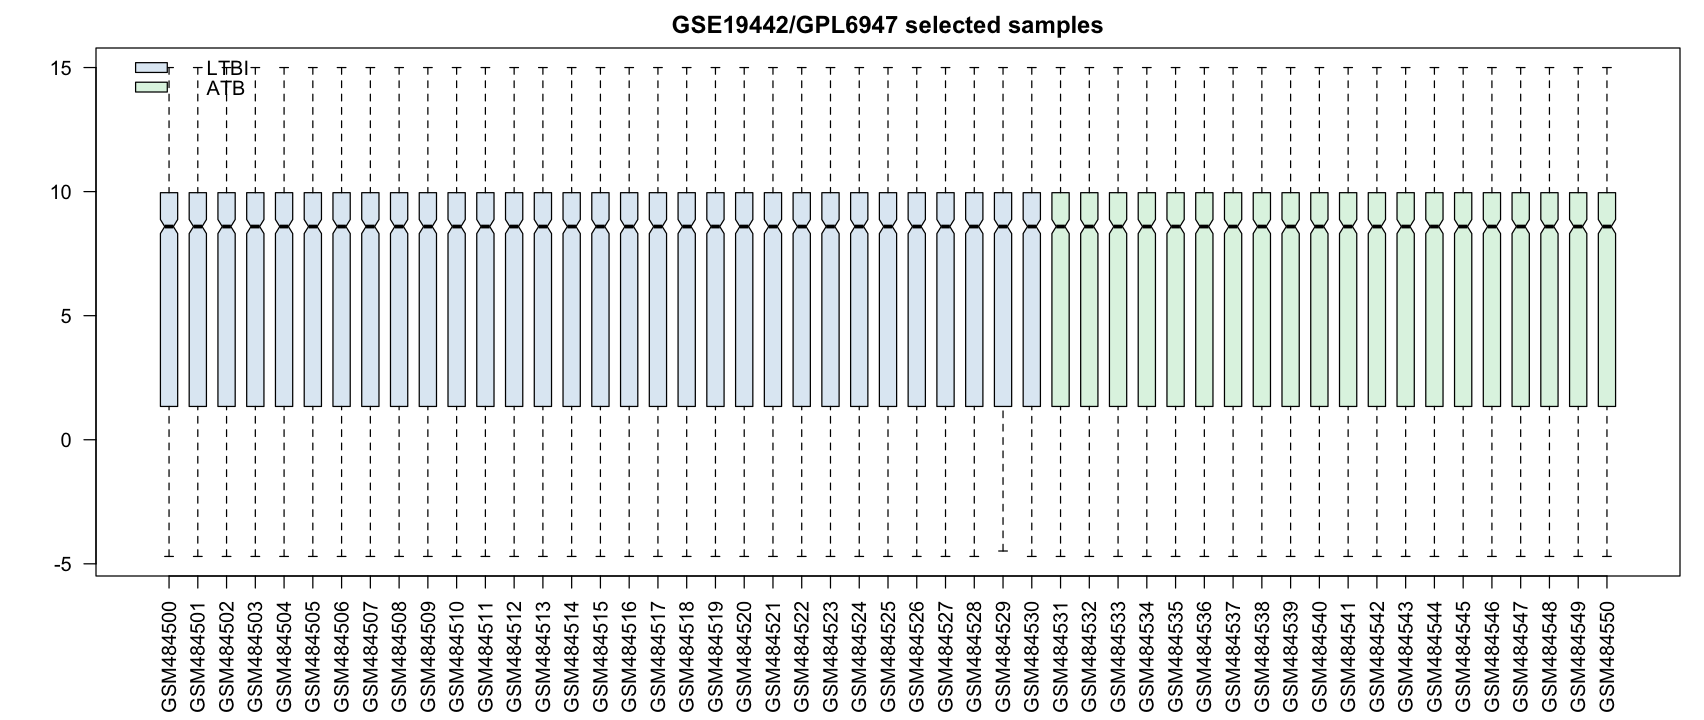

In [12]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [13]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE19442_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE19442_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL6947 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL6947.annot.gz 
Warning message:
“Partial NA coefficients for 1526 probe(s)”

## Dataset 3

### GSE19491: GSE19444: Blood Transcriptional Profiles of Active and Latent TB UK (microarray, GPL6947)

- Subjects:54
- Disease status: PTB (n=21), Latent (n=21), Control (BCG+) (n=12)
- Disease status definition: same as above

Compare ATB (**n=21**) to LTBI (**n=21**)

In [14]:
gsms <- "11110000XX1100011XX00001111XX00001111XXX000110110X10XX"
labels <- c("LTBI","ATB")
GSE_ID <- "GSE19444"
microarray_platorm <- "GPL6947"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE19444_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


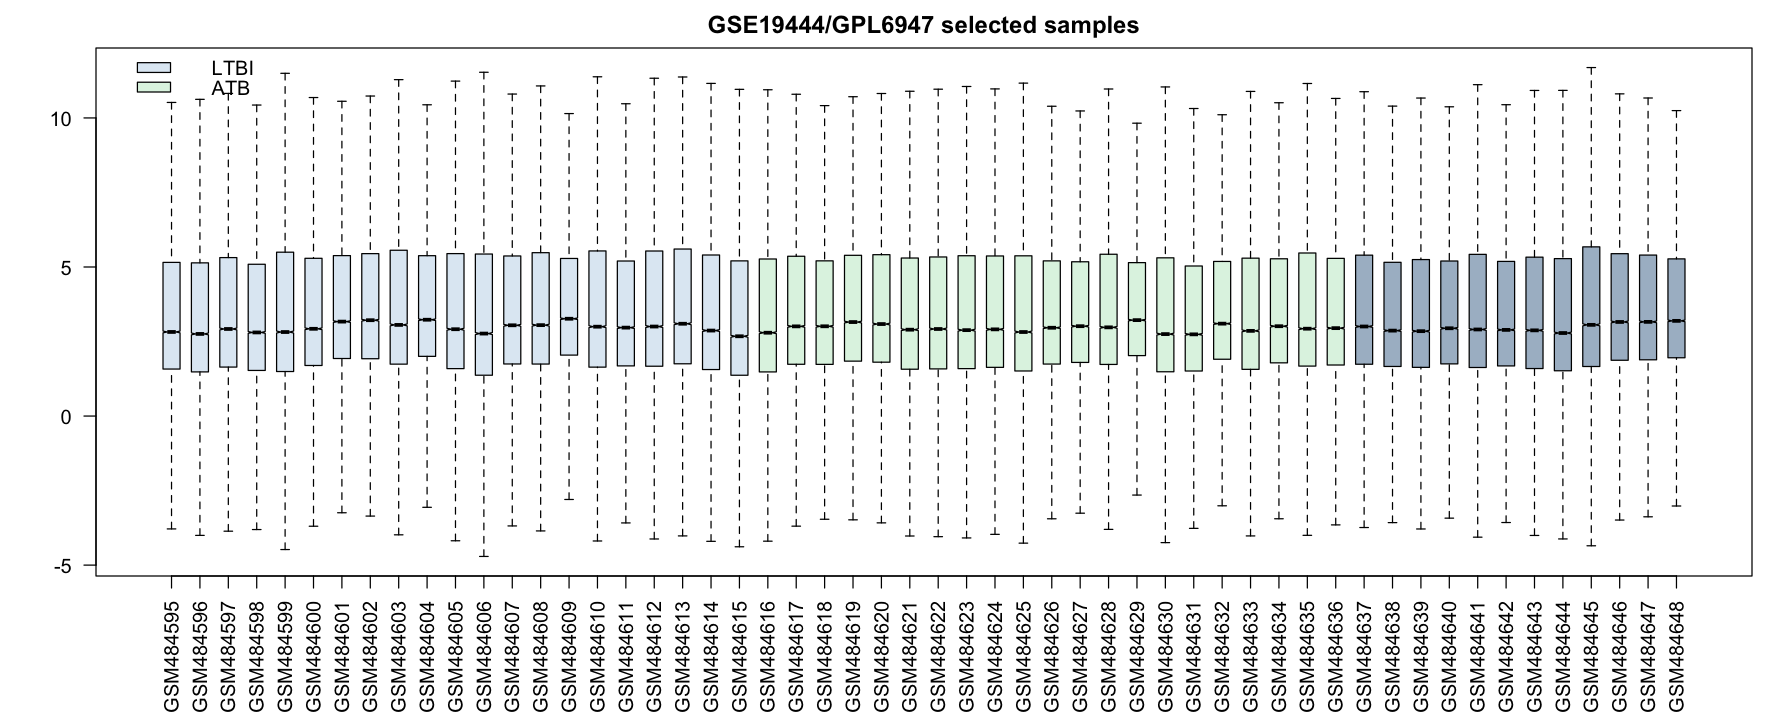

In [15]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE19444_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE19444_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


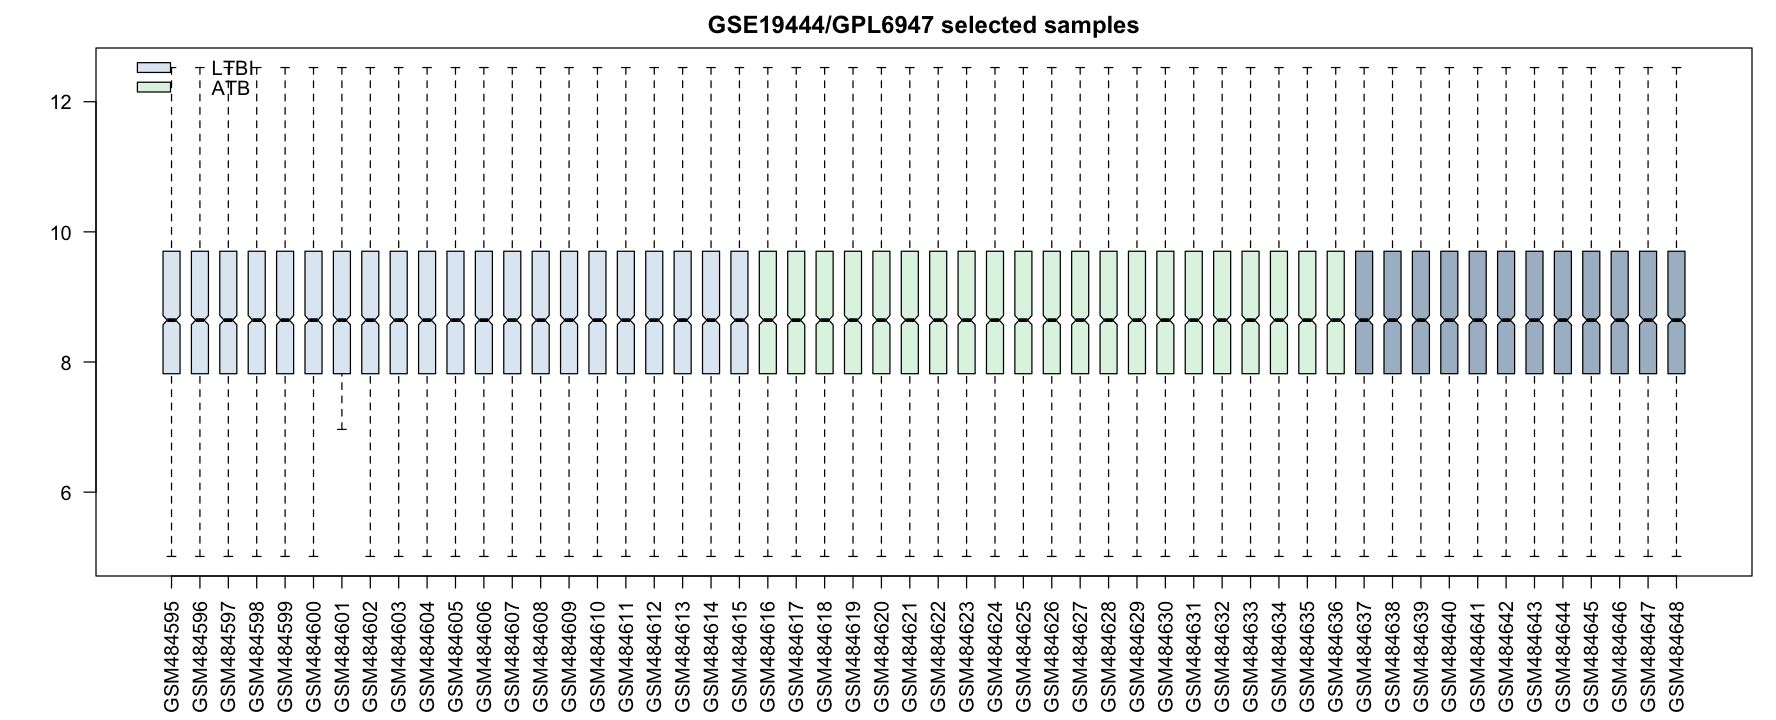

In [16]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [17]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE19444_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE19444_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL6947 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL6947.annot.gz 
Warning message:
“Partial NA coefficients for 1181 probe(s)”

## Dataset 4

### GSE28623: The Gambia, West Africa (microarray, GPL4133)

- Subjects:108
- Disease status: TB (n=46), LTBI(skin test >= 10mm)(n=25), NID(skin test = 0mm)(n=37)
- Disease status definition: TB patients showed sputum smear and chest x-ray positive. LTBI with Mantoux test induration (skin test) >= 10mm. Control with Mantoux test induration (skin test) = 0mm

Compare ATB (**n=46**) to LTBI (**n=25**)

In [18]:
gsms <- paste0("X00X100X11X1011X0X1X0101XX100XXX001X11X1X110011X1X",
        "X101101111111XXX1XX110101111X0X00X0XXX11111111X1XX",
        "XXXX000X")
labels <- c("LTBI","ATB")
GSE_ID <- "GSE28623"
microarray_platorm <- "GPL4133"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE28623_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


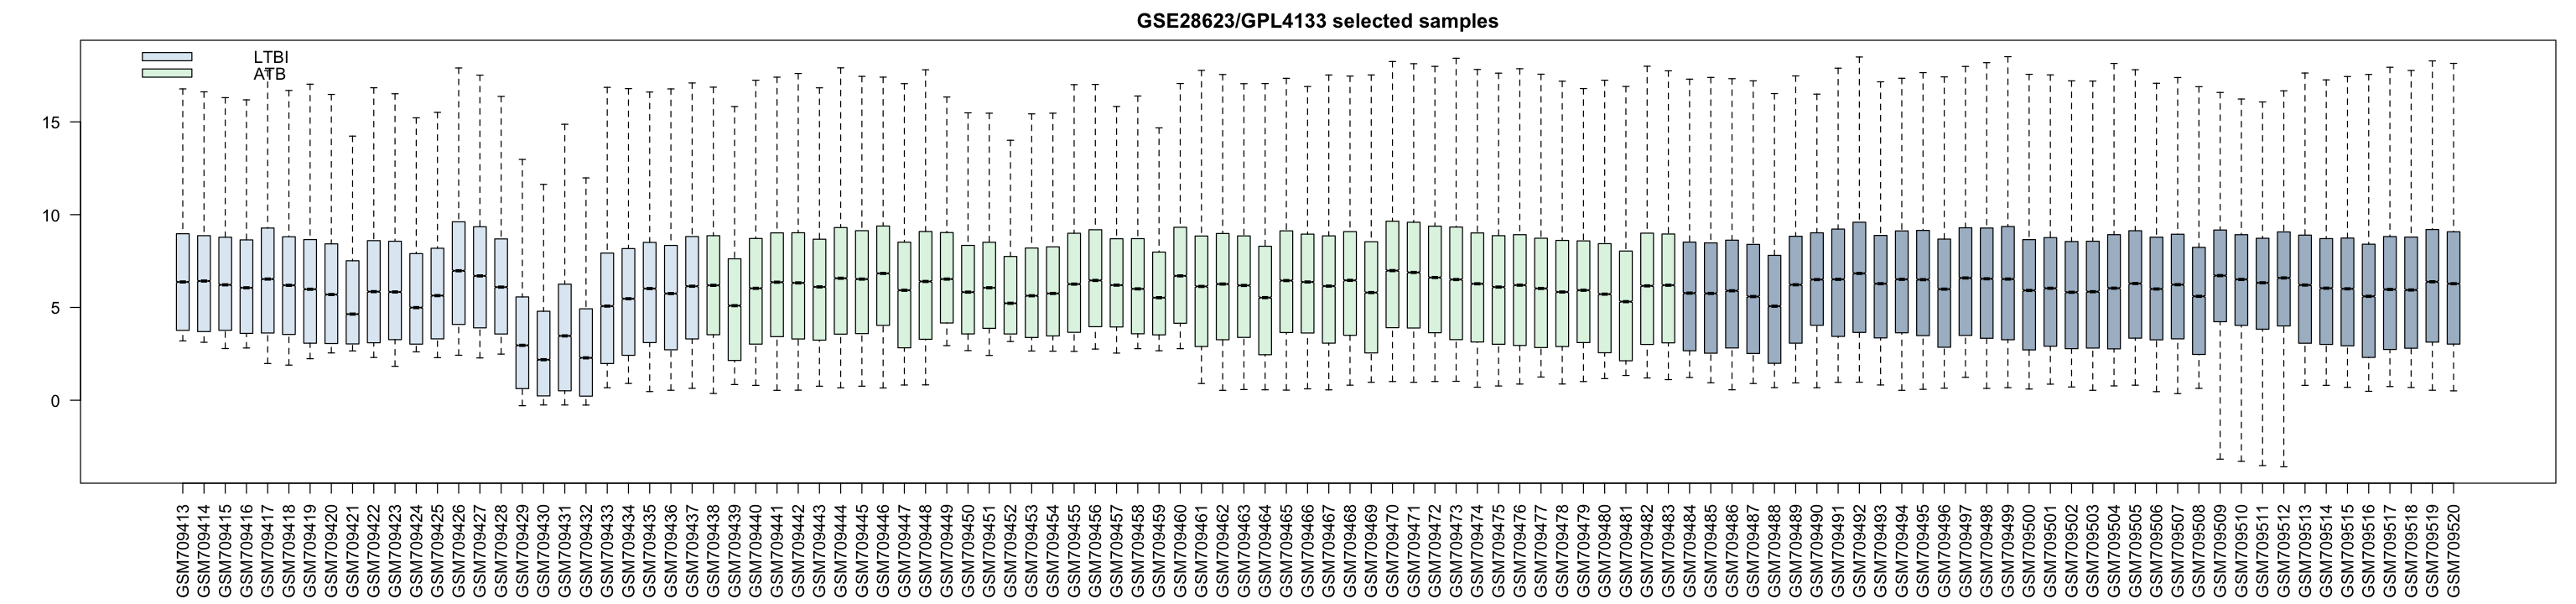

In [19]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE28623_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE28623_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


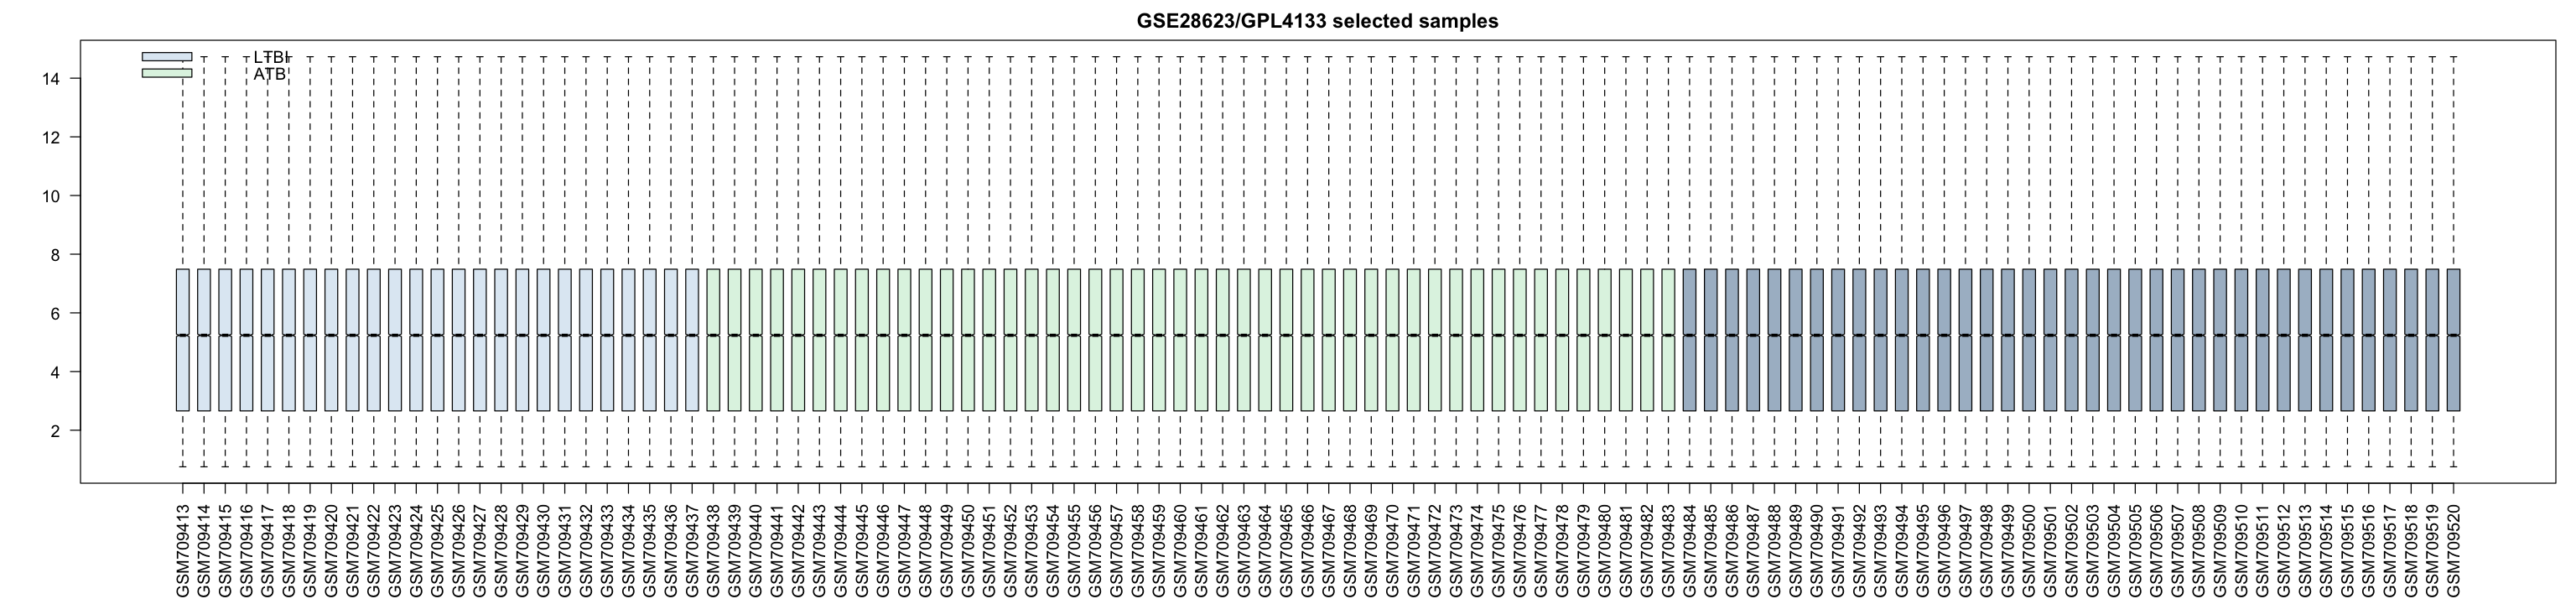

In [20]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [21]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE28623_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE28623_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL4133.annot.gz


## Dataset 5

### GSE37250 Cape Town, South Africa (n=300) and Karonga, Malawi (n=237) (microarray, GPL10558)

- Subjects:537
- Disease status: active tuberculosis (n=195), latent TB infection (n=167), other disease (n=175)
- Disease stage (the second layer): HIV positive (n=274) and negative (n=263)
- Disease status definition: active TB (TB) compared to latent TB infection (LTBI) as well as to other diseases (OD)

Compare ATB (**n=195**) to LTBI (**n=167**)

In [22]:
gsms <- paste0("11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111100000",
        "00000000000000000000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "00000000000000000000000000000000000000000000000000",
        "000000000000XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
labels <- c("LTBI","ATB")
GSE_ID <- "GSE37250"
microarray_platorm <- "GPL10558"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE37250_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


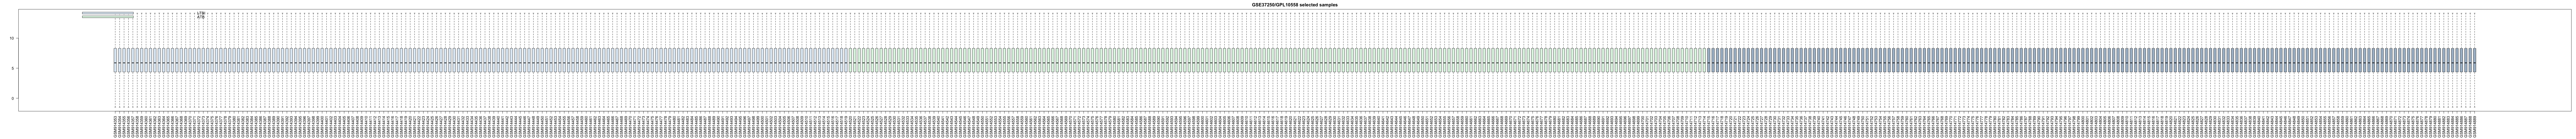

In [23]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE37250_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE37250_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


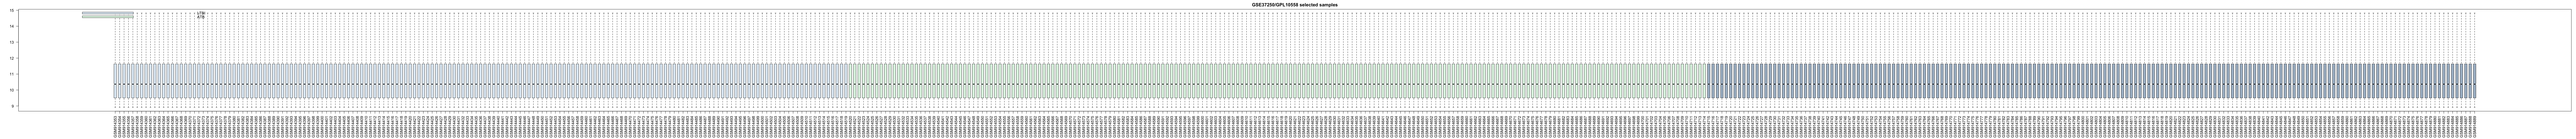

In [24]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [25]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE37250_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE37250_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL10558.annot.gz
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”Warning message:
“Partial NA coefficients for 1249 probe(

## Dataset 6

### GSE39939 A paediatric cohort from Kenya with HIV+/- (microarray, GPL10558)

- Subjects:157
- Disease status: active tuberculosis (culture confirmed) (n=35), other disease (n=55), latent TB infection (n=14), active tuberculosis (culture negative)(n=44), other disease (IGRA +)(n=9)
- Disease stage (the second layer): HIV positive (n=274) and negative (n=263)
- Disease status definition: active TB (culture confirmed), active TB (culture negative), LTBI or other disease

Compare ATB (**n=35**) to LTBI (**n=14**)

In [26]:
gsms <- paste0("1111111111XXXXXXXXXXXXXXXXXXXXXXXXXXXXX11111111111",
        "11111111111111XXXXXXXXXXXXXXXXXXXXXXXXXX0000000000",
        "0000XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXX")
labels <- c("LTBI","ATB")
GSE_ID <- "GSE39939"
microarray_platorm <- "GPL10558"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE39939_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


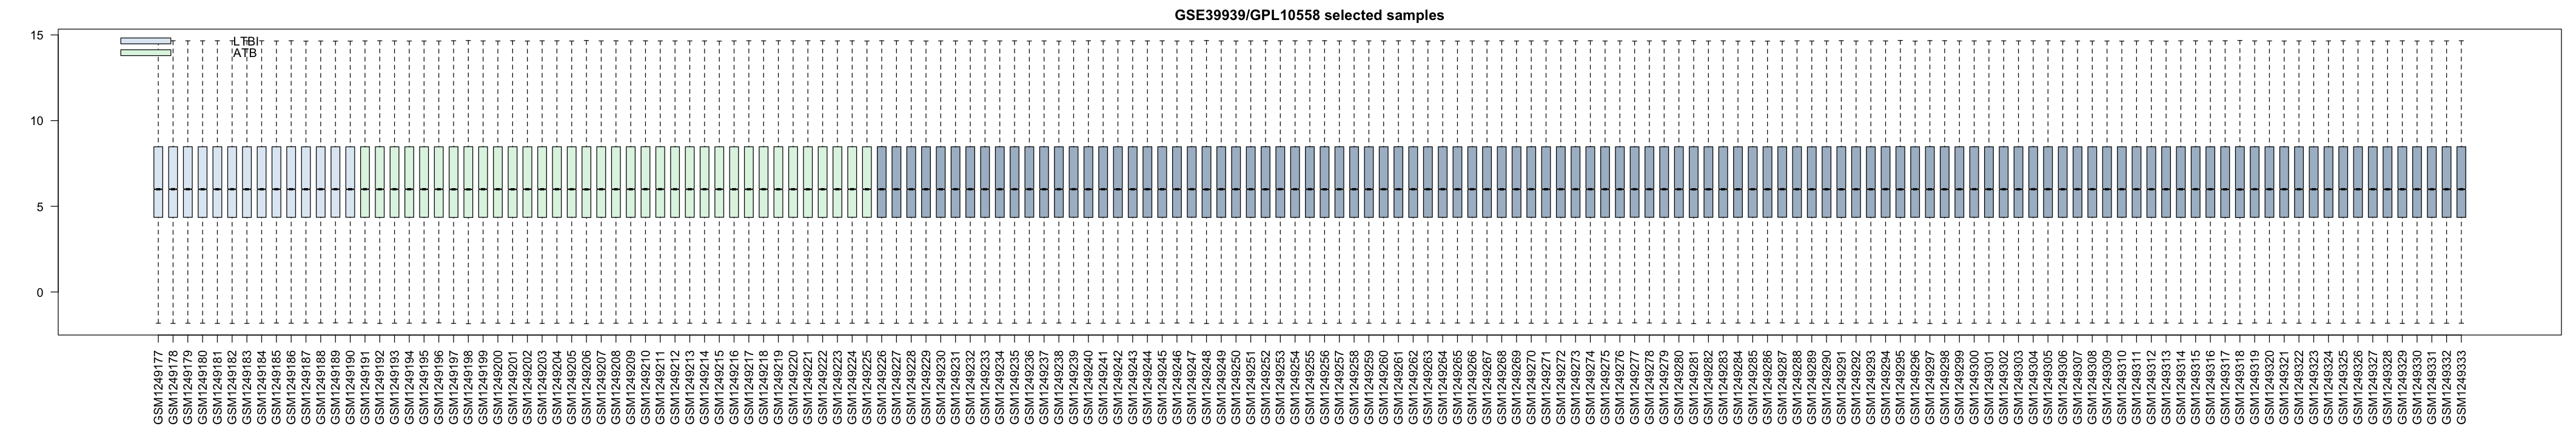

In [27]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE39939_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE39939_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


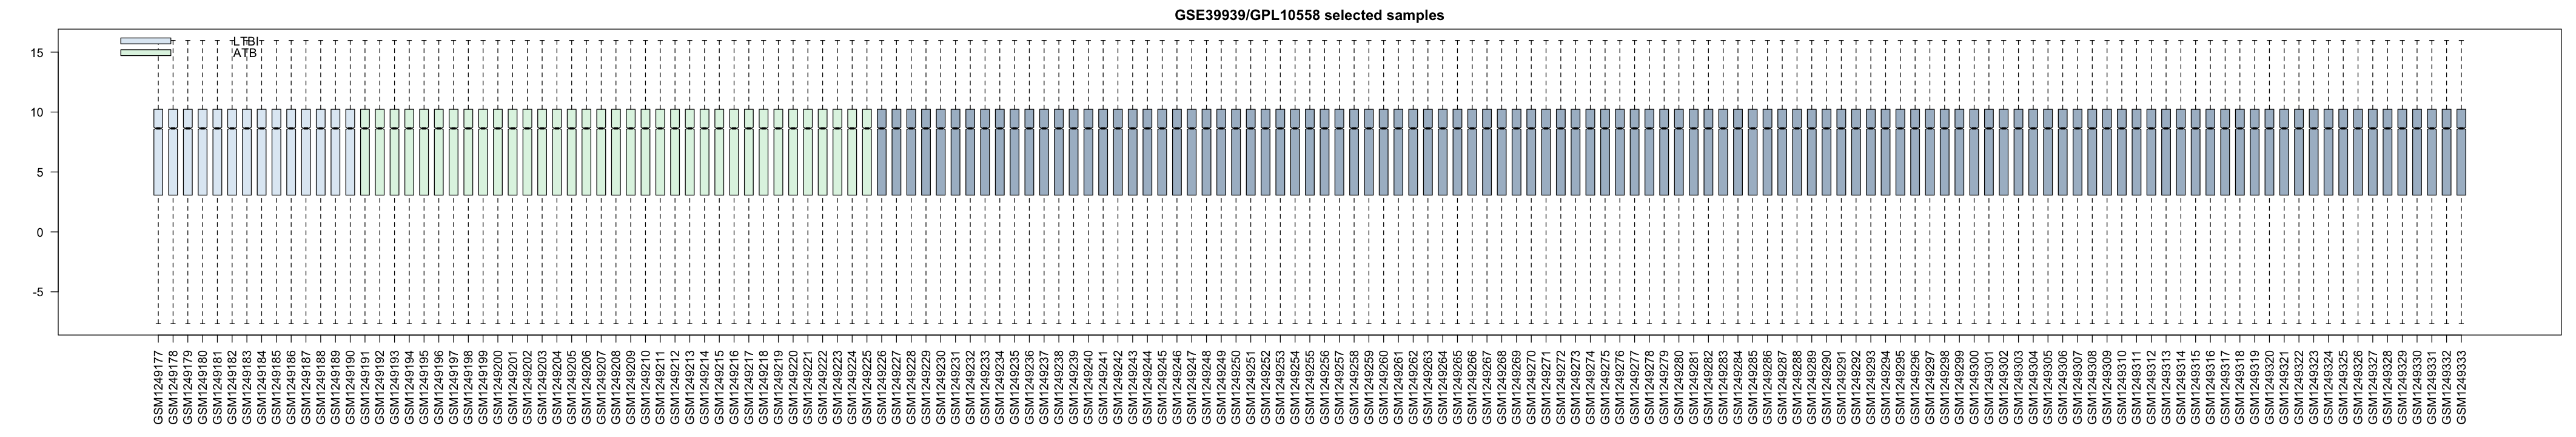

In [28]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [29]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE39939_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE39939_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”Warning message:
“Pa

## Dataset 7

### GSE39940 Cape Town, South Africa (n=157) and Blantyre, Malawi (n=177) (microarray, GPL10558)

- Subjects:334
- Disease status: active tuberculosis (n=111), latent TB infection (n=54), other disease (n=169)
- Disease stage (the second layer): HIV positive (n=107) and negative (n=227)
- Disease status definition: active TB (TB) compared to latent TB infection (LTBI) as well as to other diseases (OD)

Compare ATB (**n=111**) to LTBI (**n=54**)

In [30]:
gsms <- paste0("11111111111111111111111111111111111111111111111111",
        "11111111111111111111111111111111111111111111111111",
        "11111111111000000000000000000000000000000000000000",
        "000000000000000XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
labels <- c("LTBI","ATB")
GSE_ID <- "GSE39940"
microarray_platorm <- "GPL10558"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE39940_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


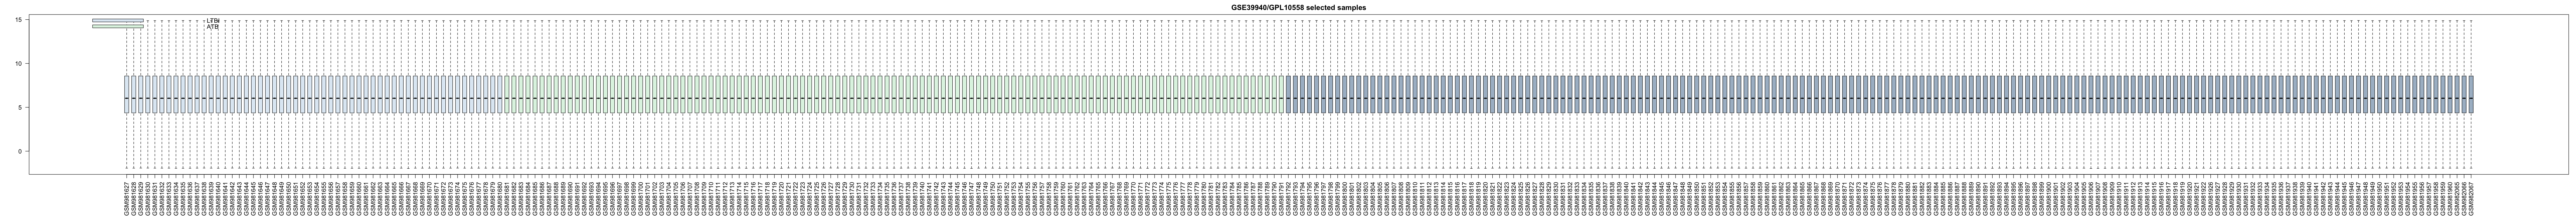

In [31]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE39940_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE39940_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


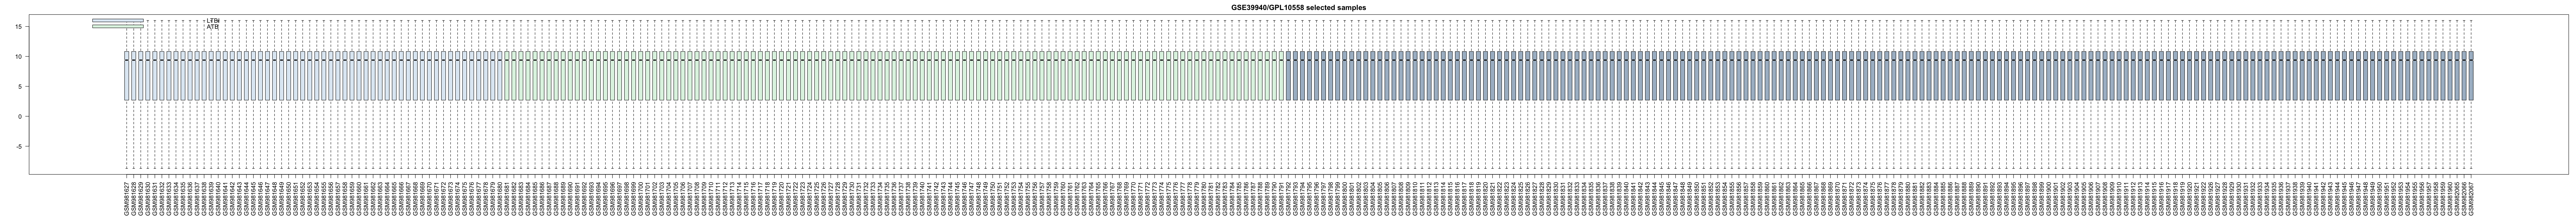

In [32]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [33]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE39940_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE39940_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”Warning message:
“Pa

## Dataset 8

### GSE41055 Venezuela, Warao Amerindian children (microarray, GPL5175)

- Subjects:27
- Disease status: whole blood, active TB infection (n=9), whole blood, latent TB infection (n=9), whole blood, healthy control (n=9)
- Disease status definition: children 1 to 15 years of age, HIV-negative. LTBI was defined as a TST = 10mm and a positive QFT-GIT with a negative culture result on inclusion in the absence of radiological and clinical evidence of TB disease on inclusion as well as on t=6 and t=12 months. HC were children with a TST = 0 mm at inclusion and at t=6 and t=12 months and a negative QFT-GIT and a negative culture result at inclusion without radiological or clinical evidence of TB disease on inclusion nor on t=6 and t=12 months. 

Compare ATB (**n=9**) to LTBI (**n=9**)

In [34]:
gsms <- "XXXXXXXXX000000000111111111"
labels <- c("LTBI","ATB")
GSE_ID <- "GSE41055"
microarray_platorm <- "GPL5175"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE41055_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


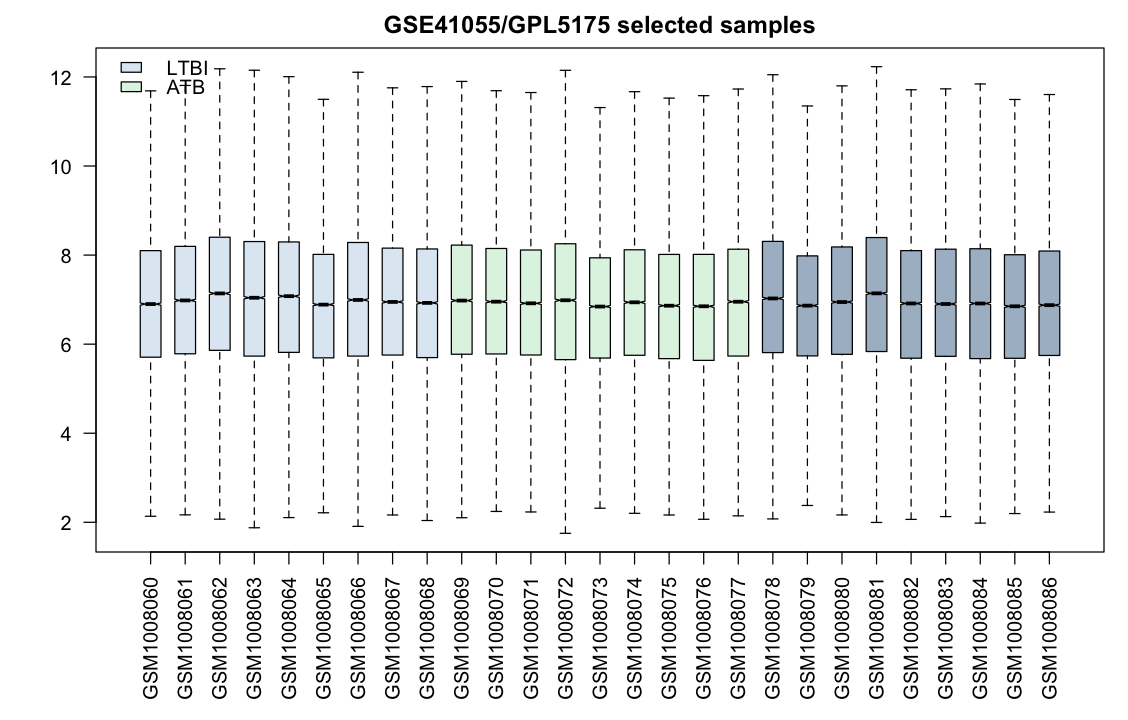

In [35]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE41055_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE41055_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


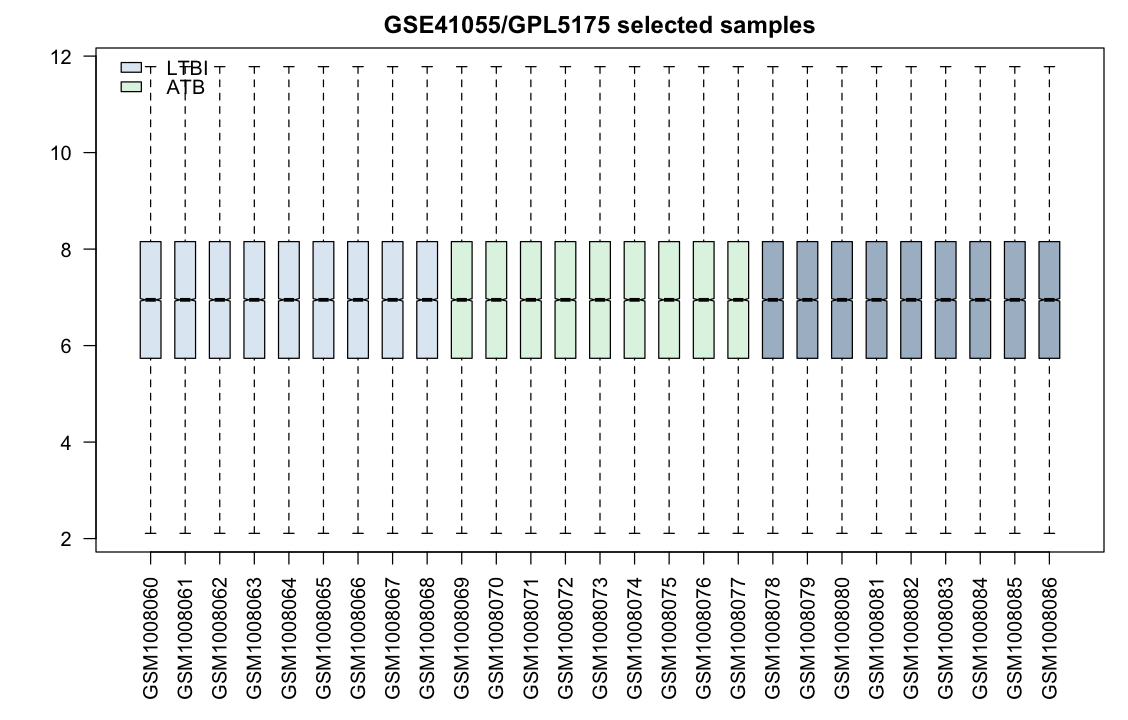

In [36]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [37]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE41055_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE41055_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.
Warning message in download.file(myurl, destfile, mode = mode, quiet = TRUE, method = getOption("download.file.method.GEOquery")):
“cannot open URL 'https://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL5nnn/GPL5175/annot/GPL5175.annot.gz': HTTP status was '404 Not Found'”Annotation GPL not available, so will use submitter GPL instead
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL5175.soft


## Dataset 9

### GSE50834 HIV and HIV/TB coninfection from South African cohort (microarray, GPL10558) (PBMC)

- Subjects:44
- Disease status: HIV only (n=21), HIV/TB (n=23)
- Disease status definition: HIV, HIV/TB

Compare ATB (**n=21**) to LTBI (**n=23**)

In [38]:
gsms <- "00000000000000000000000111111111111111111111"
labels <- c("LTBI","ATB")
GSE_ID <- "GSE50834"
microarray_platorm <- "GPL10558"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE50834_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


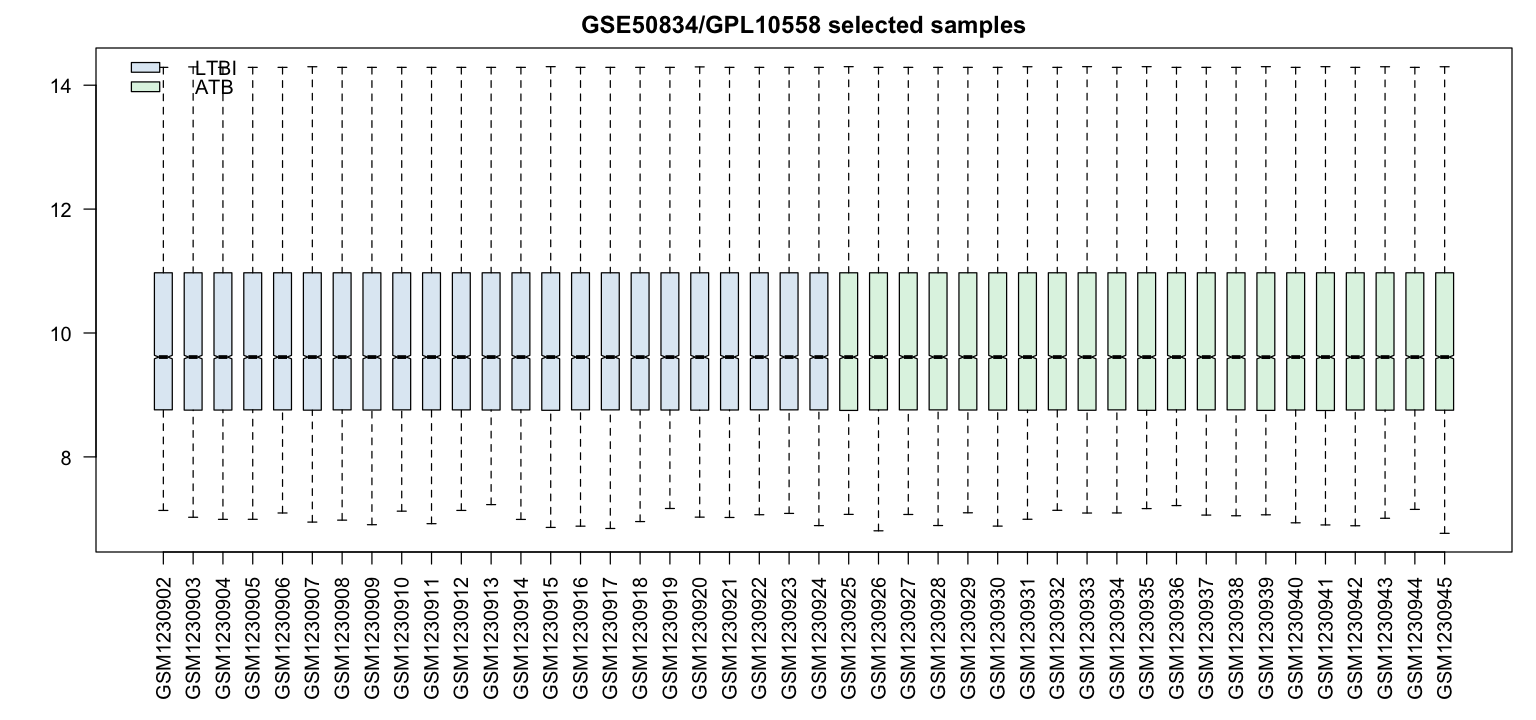

In [39]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE50834_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE50834_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


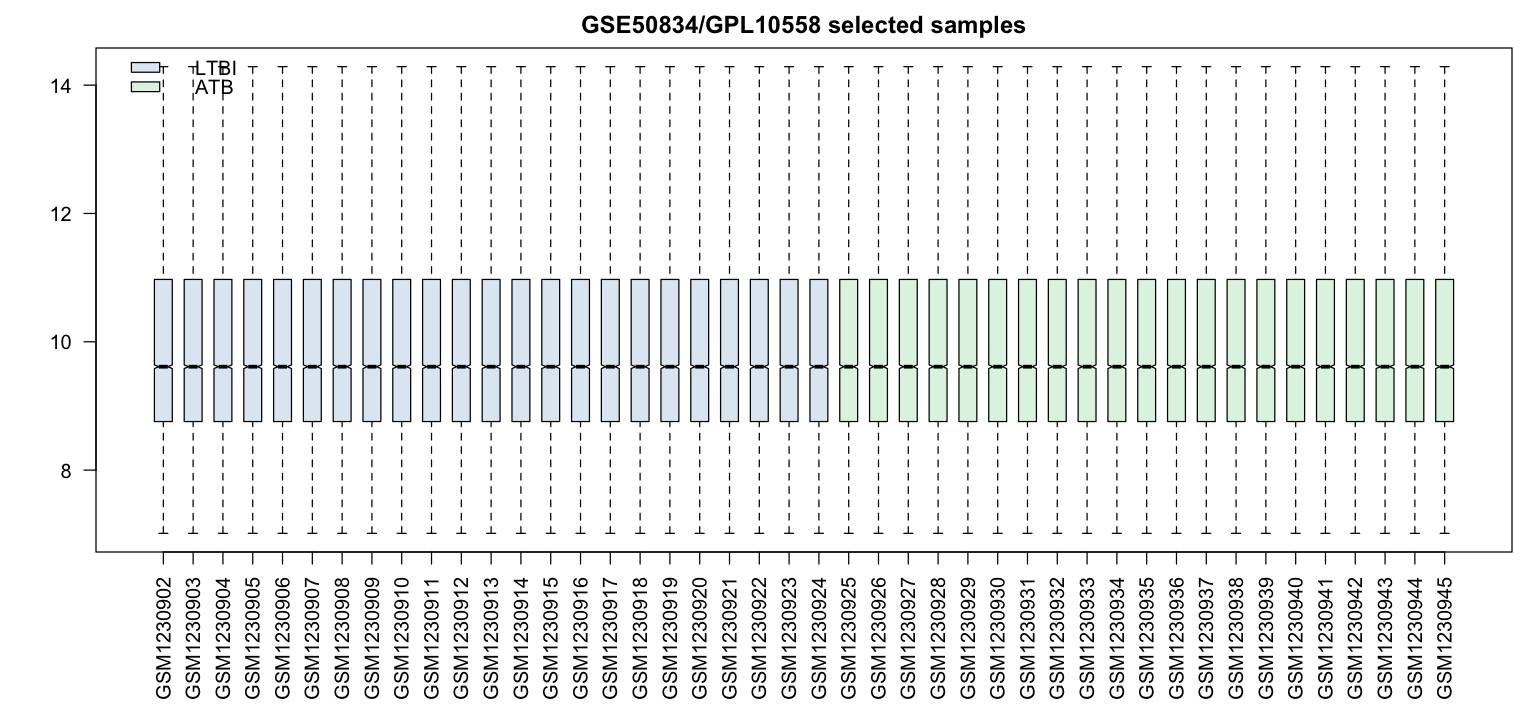

In [40]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [41]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE50834_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE50834_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”

## Dataset 10

### GSE54992 China (microarray, GPL570)

- Subjects:39
- Disease status: tuberculosis (n=9), latent tuberculosis infection (n=6), TB patient after anti-tuberculosis treatment for 3 months (n=9), TB patient after anti-tuberculosis treatment for 6 months (n=9), and healthy donor (n=6)

Compare ATB (**n=9**) to LTBI (**n=6**)

In [42]:
gsms <- "111111X1X1XXX01XX0X0X00XX0XXXXXXXXXXXXX"
labels <- c("LTBI","ATB")
GSE_ID <- "GSE54992"
microarray_platorm <- "GPL570"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE54992_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


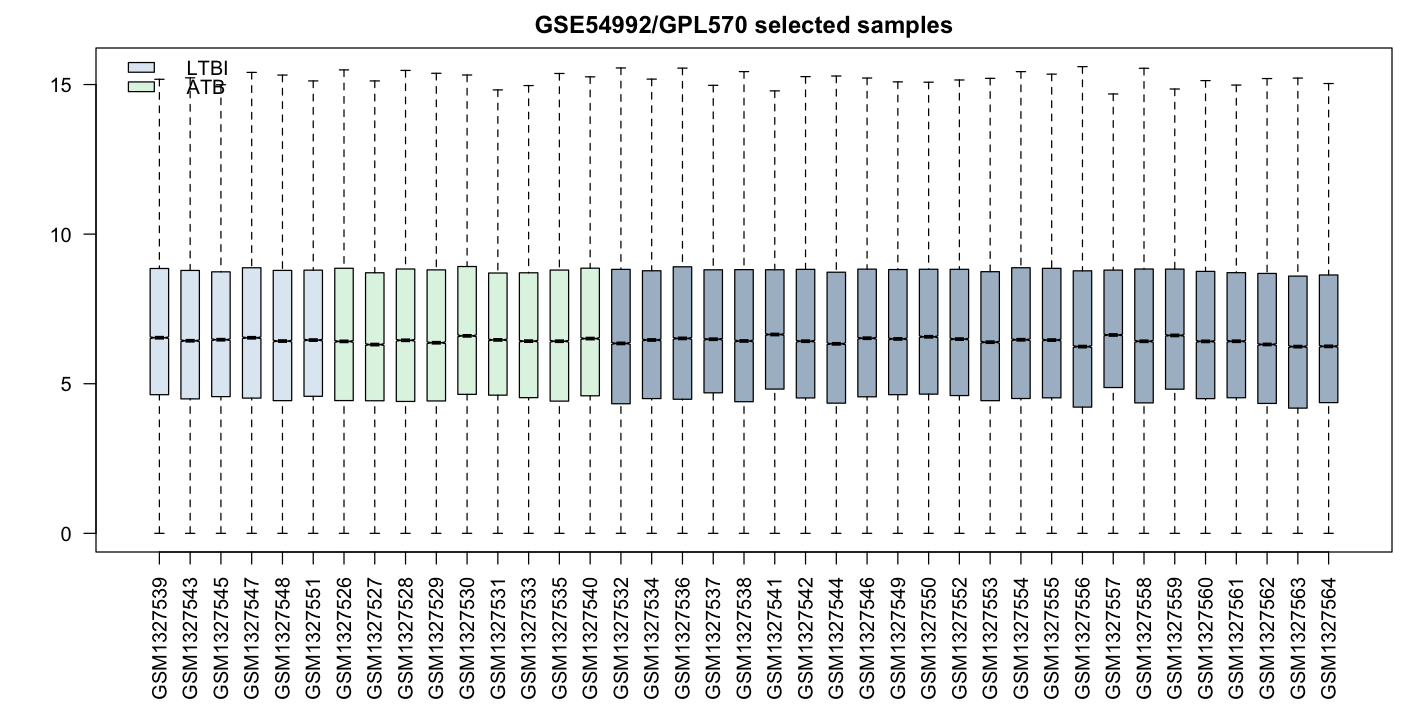

In [43]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE54992_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE54992_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


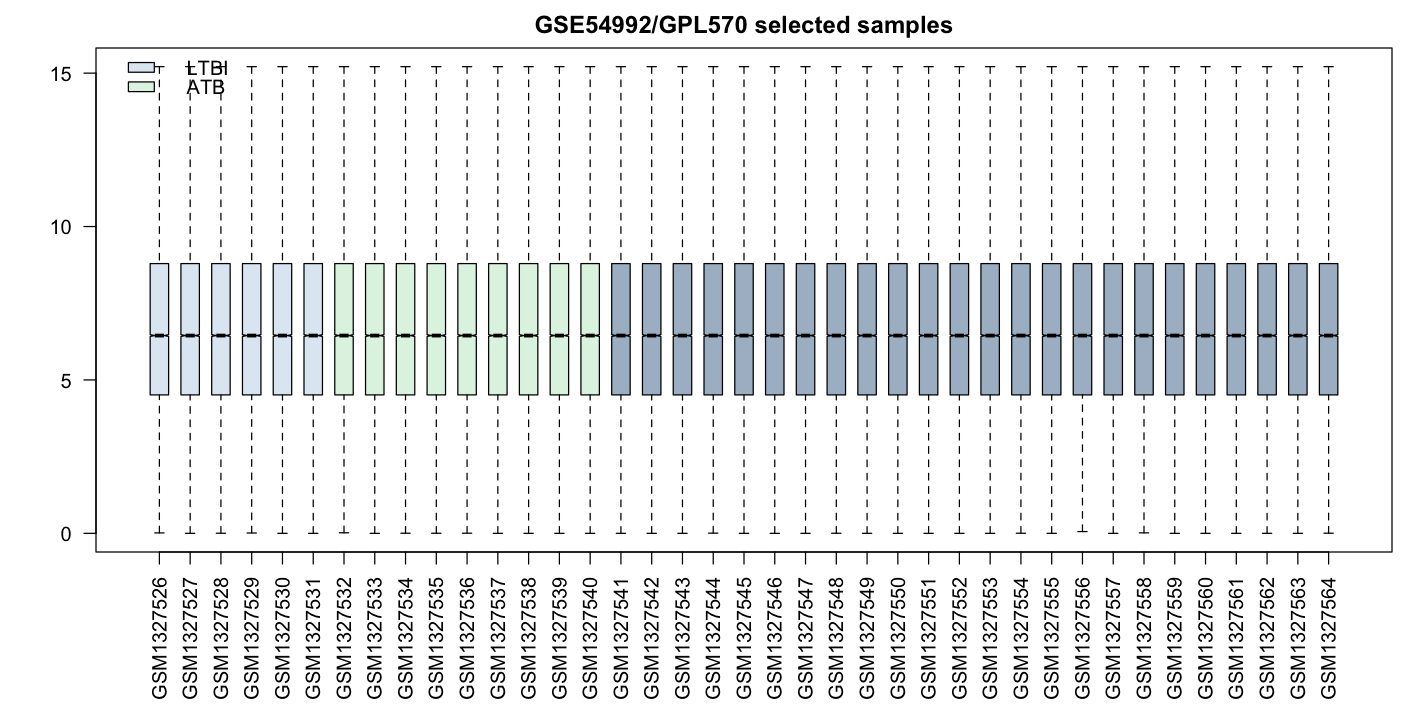

In [44]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [45]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE54992_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE54992_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL570.annot.gz
Warning message:
“62 parsing failures.
  row             col           expected    actual         file
54614 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
54615 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
54616 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
54617 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
54618 Platform_SPOTID 1/0/T/F/TRUE/FALSE --Control literal data
..... ............... .................. ......... ............
See problems(...) for more details.
”

## Dataset 11

### GSE62525 Taiwanese (microarray, GPL16951)

- Subjects:21 (42 samples total)
- Two replicates included per subject 
- Disease status: active TB (n=14), latent TB infection (n=14), and healthy control (n=14)

Compare ATB (**n=14**) to LTBI (**n=14**)

In [46]:
gsms <- "XXXXXXXXXXXXXX0000000000000011111111111111"
labels <- c("LTBI","ATB")
GSE_ID <- "GSE62525"
microarray_platorm <- "GPL16951"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE62525_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


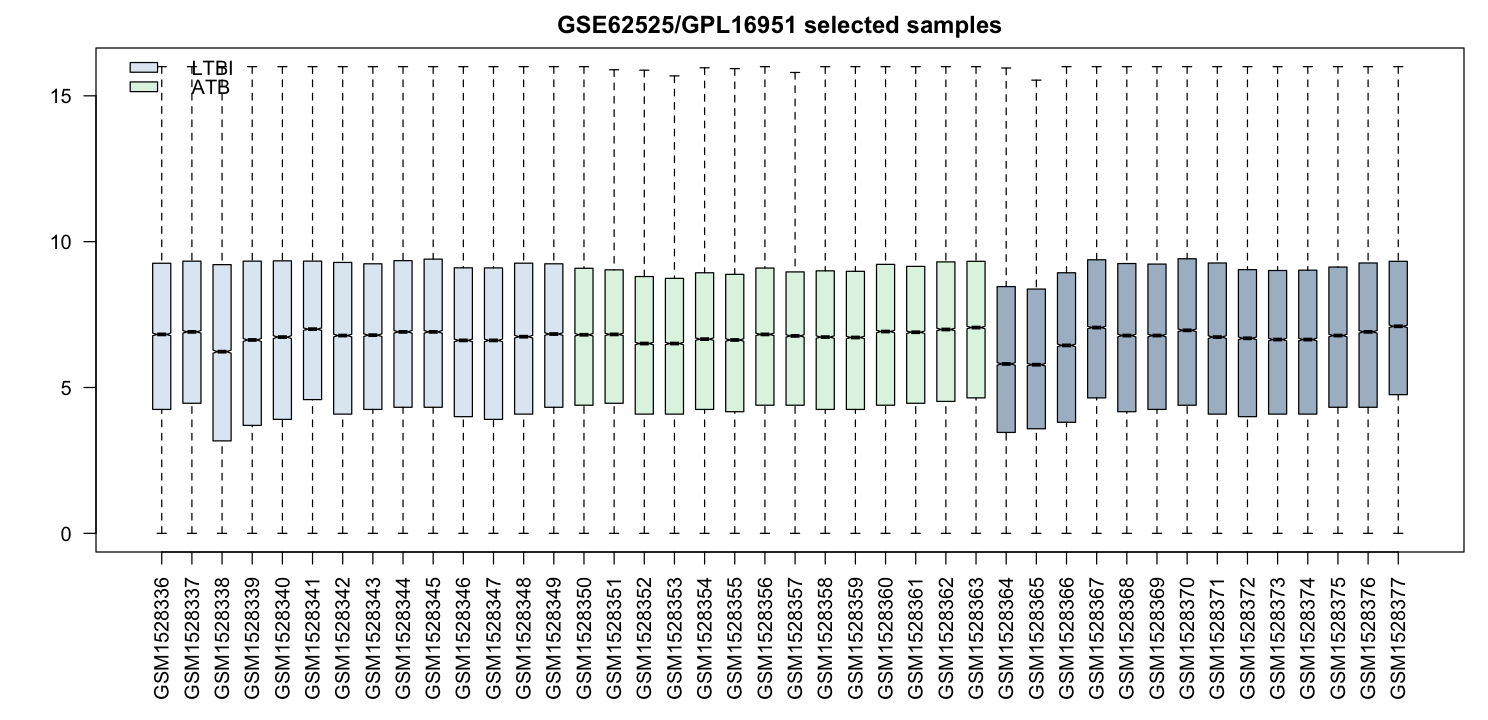

In [47]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE62525_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE62525_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


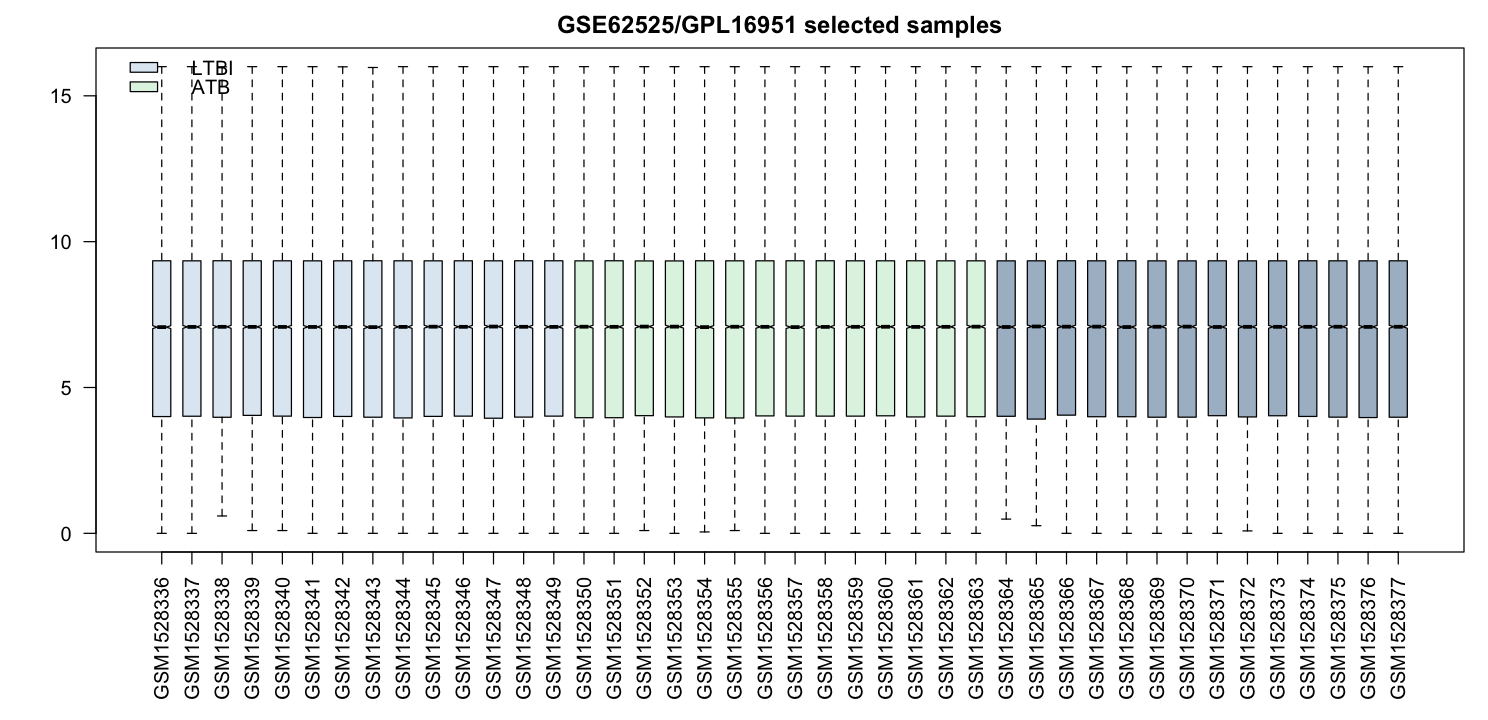

In [48]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [49]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE62525_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE62525_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Warning message in download.file(myurl, destfile, mode = mode, quiet = TRUE, method = getOption("download.file.method.GEOquery")):
“cannot open URL 'https://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL16nnn/GPL16951/annot/GPL16951.annot.gz': HTTP status was '404 Not Found'”Annotation GPL not available, so will use submitter GPL instead
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL16951.soft
Warning message:
“Partial NA coefficients for 5 probe(s)”

## Dataset 12

### GSE69581 South Africa HIV infected latent/active TB patients (microarray, GPL10558)

- Subjects:50
- Disease status: Active (n=15), Latent (n=25), and Subclinical (n=10)
- Disease status definition: active: symptomatic microbiologically confirmed active pulmonary TB. Subclinical had pulmonary abnormalities consistent with subclinical disease and were significantly more likely to progress

Compare ATB (**n=15**) to LTBI (**n=25**)

In [50]:
gsms <- "1111111111111110000000000000000000000000XXXXXXXXXX"
labels <- c("LTBI","ATB")
GSE_ID <- "GSE69581"
microarray_platorm <- "GPL10558"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE69581_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


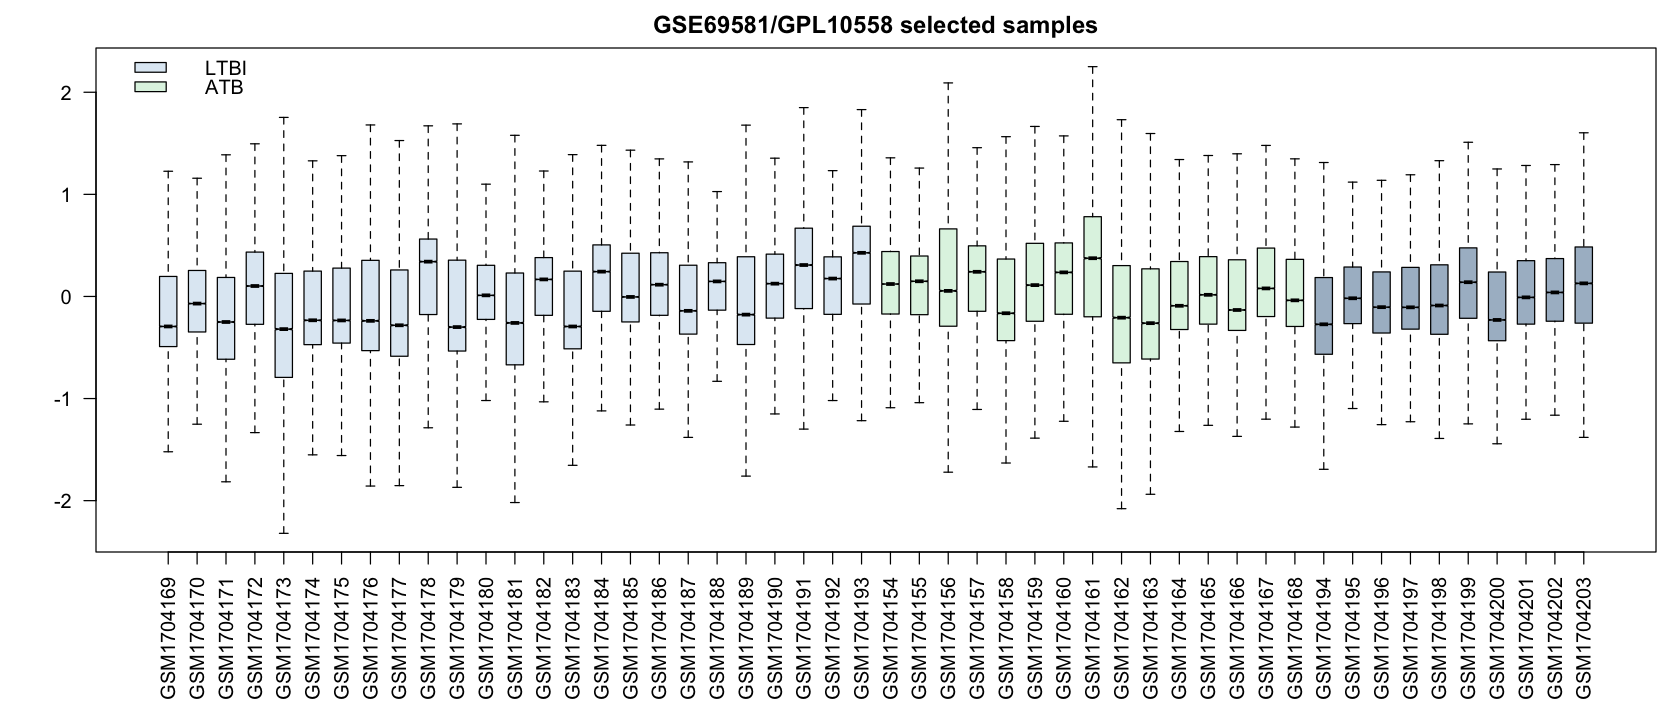

In [51]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE69581_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE69581_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.


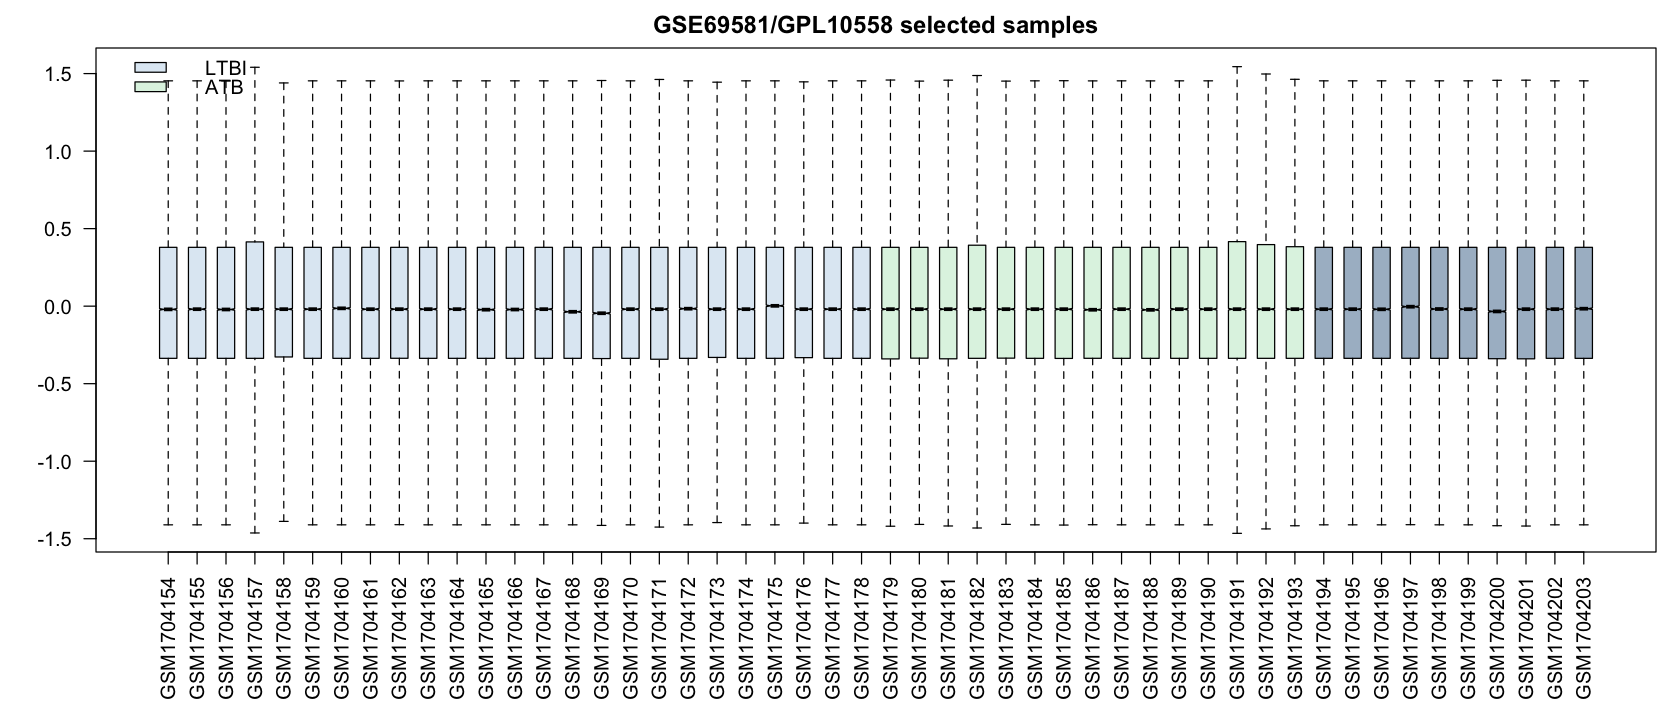

In [52]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [53]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE69581_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE69581_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
Using locally cached version of GPL10558 found here:
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL10558.annot.gz 
Warning message:
“13 parsing failures.
  row     col               expected          actual         file
29686 Gene ID no trailing characters ///283507       literal data
29841 Gene ID no trailing characters ///2074         literal data
30401 Gene ID no trailing characters ///27185///7257 literal data
31184 Gene ID no trailing characters ///57592        literal data
31271 Gene ID no trailing characters ///3199         literal data
..... ....... ...................... ............... ............
See problems(...) for more details.
”

## Dataset 13

### GSE73408 US patients with TB and pneumonia  (microarray, GPL11532)

- Subjects:109
- Disease status: TB (n=35), LTBI (n=35), and PNA (pneumonia) (n=39)
- Disease status definition: TB, LTBI, and PNA (pneumonia)

Compare ATB (**n=35**) to LTBI (**n=35**)

In [54]:
gsms <- paste0("11111111111111111111111111111111111000000000000000",
        "00000000000000000000XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX",
        "XXXXXXXXX")
labels <- c("LTBI","ATB")
GSE_ID <- "GSE73408"
microarray_platorm <- "GPL11532"

#### Check distribution of expression values across samples

Found 1 file(s)
GSE73408_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


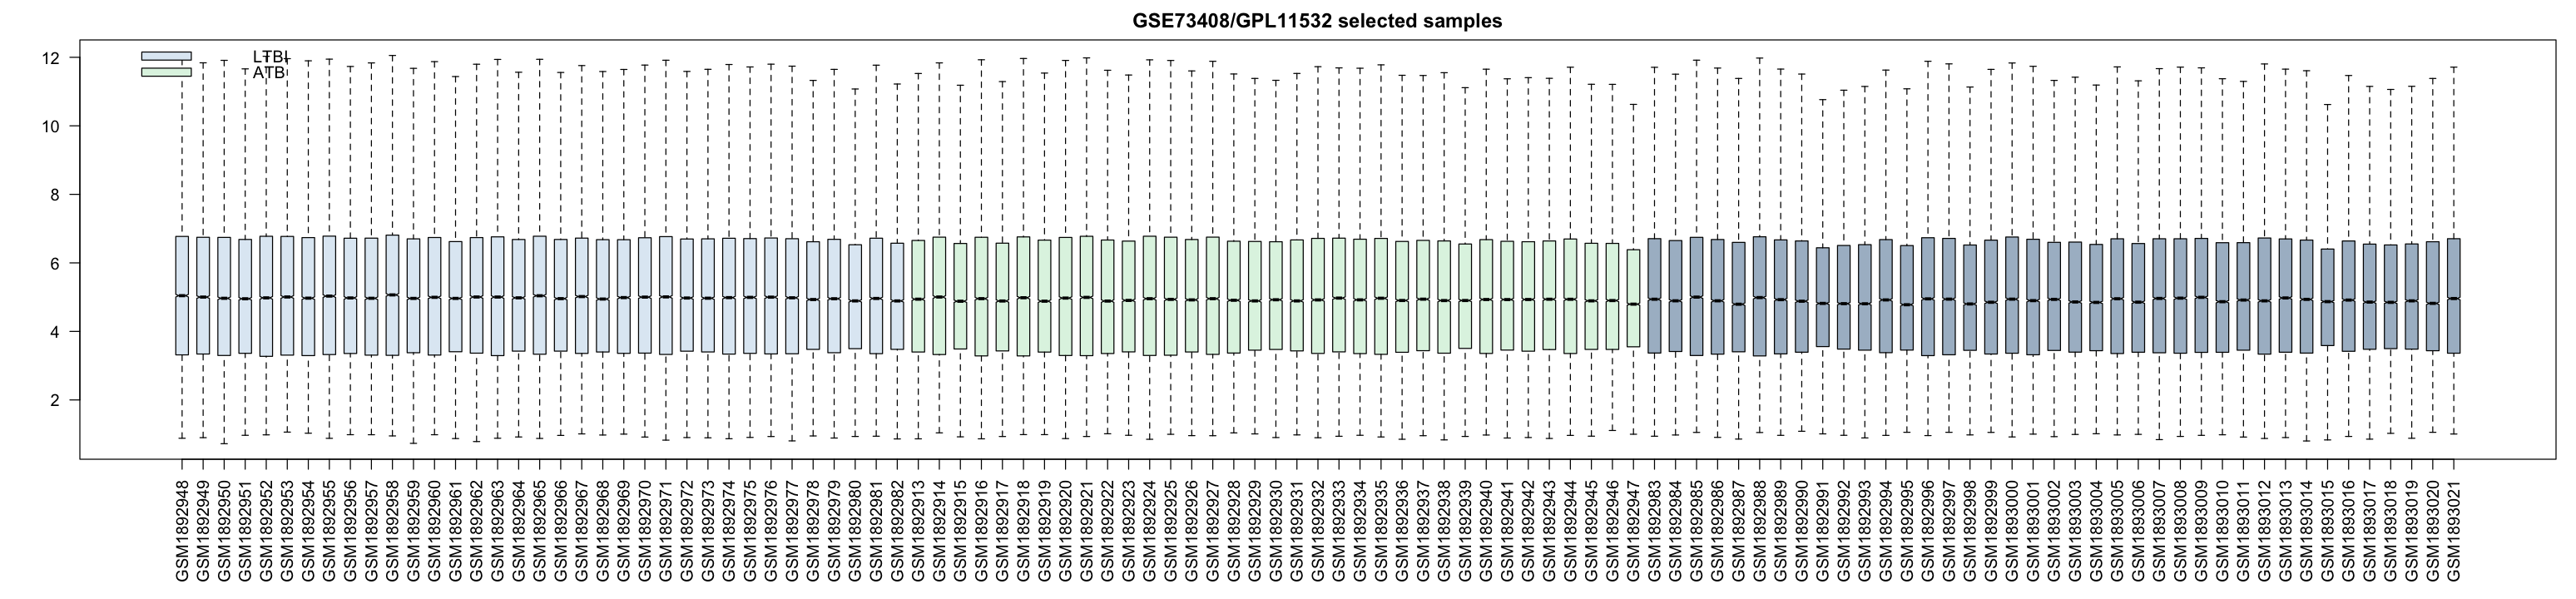

In [55]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, FALSE)

Found 1 file(s)
GSE73408_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE73408_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


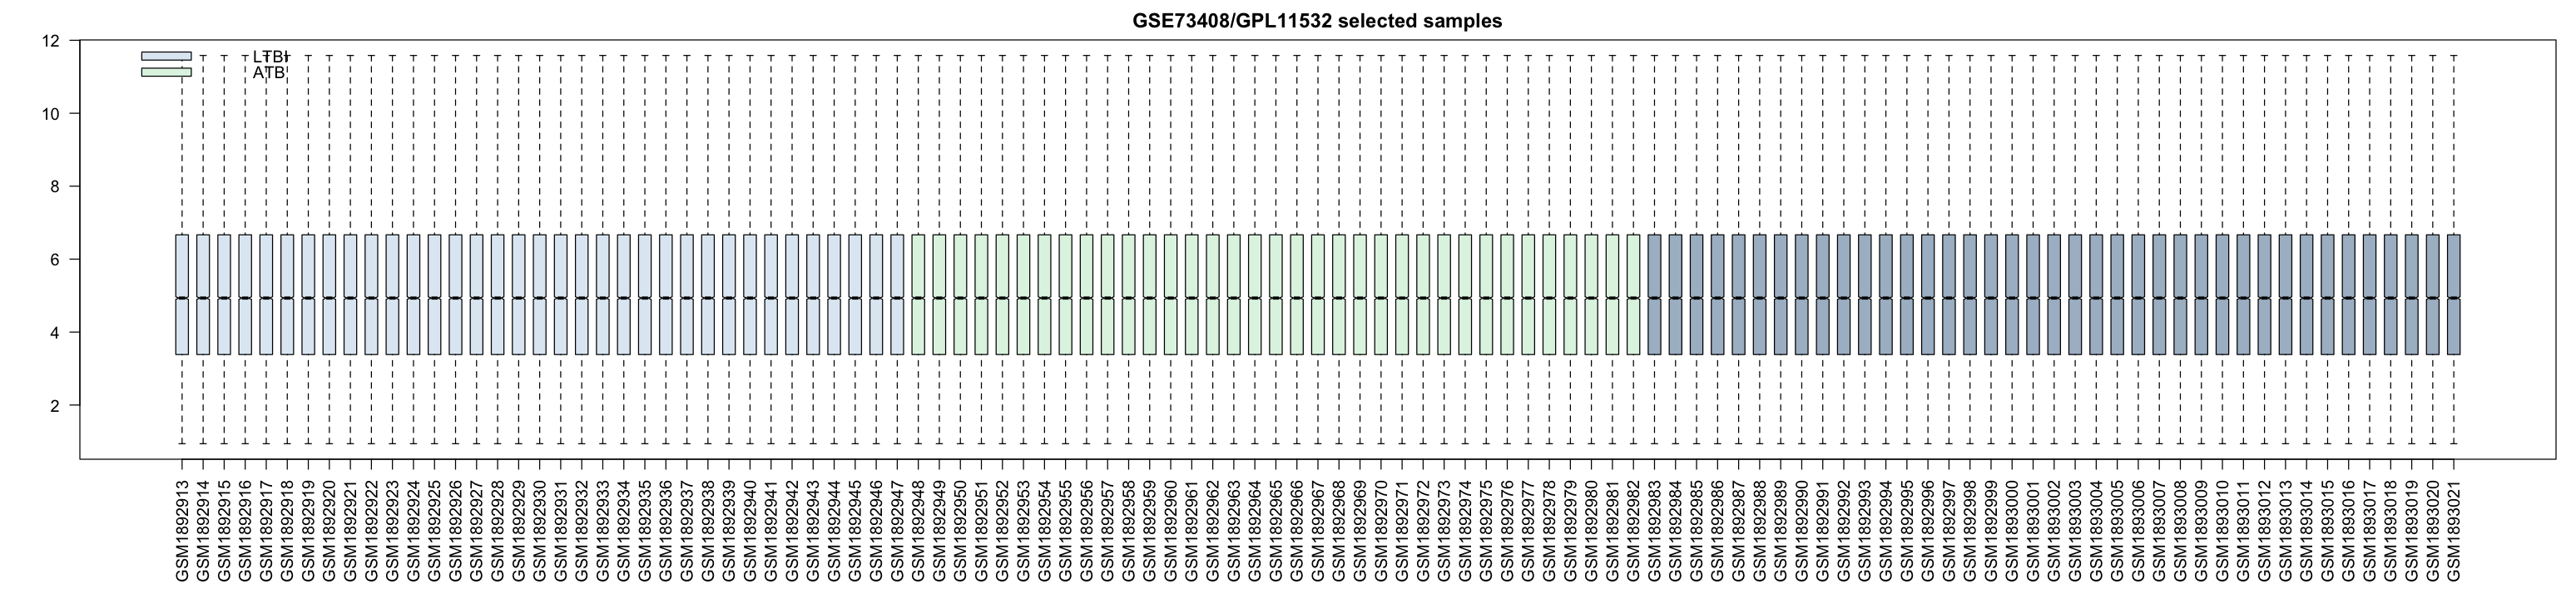

In [56]:
draw_boxplot_for_samples(GSE_ID, microarray_platorm, gsms, labels, TRUE)

#### Run differential expression analysis between sample groups and export results as CSV file

In [57]:
diff_exp_analysis_for_samples(GSE_ID, microarray_platorm, gsms, microarray_diff_exp_data, TRUE)

Found 1 file(s)
GSE73408_series_matrix.txt.gz
Using locally cached version: /var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GSE73408_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.
File stored at: 
/var/folders/qd/wxnxvl1j6x50wp2tn6rml2km0000gn/T//Rtmp2ip4le/GPL11532.annot.gz


# **RNA-seq Data**

Specify directory where RNA-seq Data is stored

In [58]:
RNAseq_counts_data <- "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/RNAseq Datasets/"

Specify directory for where to store Differential Gene Expression Data

In [59]:
RNAseq_diff_exp_data <- "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/RNAseq Differential Gene Expression/ATB_v_LTBI/"

## *Function* for differential gene expression analysis

In [60]:
diff_exp_analysis_for_samples <- function(GSE_ID, gsms, counts_filename, num_samples, TMM_norm, first_sample_column_i, last_sample_column_i, gene_symbol_col) {
    
    # Differential expression analysis with limma

    #read in counts matrix
    countsMatrix_filepath <- paste0(RNAseq_counts_data, counts_filename)
    countsMatrix_full <- read.csv(file = countsMatrix_filepath) #retrieve full counts matrix

    annotation <- countsMatrix_full[[gene_symbol_col]]
    countsMatrix <- countsMatrix_full[first_sample_column_i:last_sample_column_i] #select columns that correspond to samples

    #convert counts matrix to a dataframe
    countsMatrix <- as.data.frame(countsMatrix)

    #construct design matrix
    group <- vector()
    for (sample_i in strsplit(gsms, "")[[1]]) {
        if (sample_i == '0') {
            group <- c(group, 1)
        }
        else if (sample_i == '1') {
            group <- c(group, 2)
        }
    }
    group <- factor(group)
    design <- model.matrix(~ group + 0)

    # group names for all samples
    sml <- c()
    for (i in 1:nchar(gsms)) { sml[i] <- substr(gsms,i,i) }

    # eliminate samples marked as "X"
    sel <- which(sml != "X")
    sml <- sml[sel]
    countsMatrix <- countsMatrix[ ,sel]

    # set up the data and proceed with analysis
    sml <- paste("G", sml, sep="")    # set group names

    # rename columns of design matrix to match group names
    colnames(design) <- levels(as.factor(sml)) 

    # Put the counts, groups, and annotation into a 'DGEList' object 
    x <- DGEList(counts=countsMatrix, group=sml, genes=annotation)

    # TMM Normalization (use if counts matrix not already normalized)
    if (TMM_norm == TRUE) {
        x <- calcNormFactors(x)
    }

    # Filter out genes that don't have at least 1 count-per-million in at least number of samples / 2
    isexpr <- rowSums(cpm(x) > 1) >= num_samples / 2
    x <- x[isexpr,]

    # Run voom
    voomResults <- voom(x,design)

    #Run limma
    fit <- lmFit(voomResults, design)
    cont.matrix <- makeContrasts(G1-G0, levels=design)
    fit2 <- contrasts.fit(fit, cont.matrix)
    fit2 <- eBayes(fit2, 0.01)
    tT <- topTable(fit2, adjust="fdr", sort="none" , n=Inf)

    #save results
    write.csv(tT, paste0(RNAseq_diff_exp_data , GSE_ID, '.csv'))
}

## Dataset 14

### GSE84076 Brazil, >18 year-old  (Sequencing, GPL16791)

- Subjects:36
- Disease status: Active Tuberculosis (n=6), Treated Active Tuberculosis (n=2), Latent Tuberculosis - BCG - Unvaccinated/vaccinated (n=16) and Control - BCG - Unvaccinated/vaccinated (n=12)
- Disease status definition: Cufflinks for normalization
- rawcount = *no*

Compare ATB (**n=8**) to LTBI (**n=16**)

#### Run differential expression analysis between sample groups and export results as CSV file

In [61]:
GSE_ID = "GSE84076"
gsms <- "110000000000000000XXXXXXXXXXXX111111"
counts_filename <- "GSE84076_ExpressionDataMatrix.csv"
num_samples <- 8 + 16
TMM_norm <- FALSE
gene_symbol_col <- 'gene_id'

#first & last column indices that correspond to samples
first_sample_column_i = 2
last_sample_column_i = 37

In [62]:
diff_exp_analysis_for_samples(GSE_ID, gsms, counts_filename, num_samples, TMM_norm, first_sample_column_i, last_sample_column_i, gene_symbol_col)

## Dataset 15

### GSE101705  South Indian cohort  (Sequencing, GPL18573)

- Subjects:44
- Disease status: TB (n=28), latent TB infection (n=16)
- Disease status definition: DEseq2 normalization
- rawcount = *no*

Compare ATB (**n=28**) to LTBI (**n=16**)

#### Run differential expression analysis between sample groups and export results as CSV file

In [63]:
GSE_ID = "GSE101705"
gsms <- "11111111111111110000000000000000111111111111"
counts_filename <- "GSE101705_normalizedCounts.csv"
num_samples <- 28 + 16
TMM_norm <- FALSE
gene_symbol_col <- 'X'

#first & last column indices that correspond to samples
first_sample_column_i = 2
last_sample_column_i = 45

In [64]:
diff_exp_analysis_for_samples(GSE_ID, gsms, counts_filename, num_samples, TMM_norm, first_sample_column_i, last_sample_column_i, gene_symbol_col)

## Dataset 16

### GSE107995: GSE107994  Leicester cohort - progressor individuals (Sequencing, GPL20301)

- Subjects:175
- Disease status:  Active_TB (n=53), LTBI_Progressor (n=23), Control (n=50), LTBI (n=49)
- Disease status definition: will use edgeR TMM normalization
- Disease status definition: LTBI_Progressor samples is longitudnal datasets ranged from baseline (latent infection) to active TB diagnosed. Longitudinal data is in a low TB incidence setting.
- rawcount = *yes*

Compare ATB (**n=53**) to LTBI (**n=23+49=72**)

#### Run differential expression analysis between sample groups and export results as CSV file

In [65]:
GSE_ID = "GSE107994"
gsms <- "10000111X1X00X0X10XXX01X0X101X1001XXX011X1111XXXX110000X1X1010X01X00X0111X1000001XX110X11100XX1X0XXXXX0000110XXX000XX000011XXXXXXXXX00111X0000000001001111100000100001000111100"
counts_filename <- "GSE107994_Raw_counts_Leicester_with_progressor_longitudinal.csv"
num_samples <- 53 + 72
TMM_norm <- TRUE
gene_symbol_col <- 'Gene_name'

#first & last column indices that correspond to samples
first_sample_column_i = 4
last_sample_column_i = 178

In [66]:
diff_exp_analysis_for_samples(GSE_ID, gsms, counts_filename, num_samples, TMM_norm, first_sample_column_i, last_sample_column_i, gene_symbol_col)